In [1]:
from fmpy import read_model_description, extract
from fmpy.fmi2 import FMU2Slave
from C_T01 import C_T01
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# define the model name and simulation parameters

class PlantEnv:
    def __init__(self,CaseTest,Hysteresis,step_size):
        
        self.Hysteresis = Hysteresis     # Définit l'hystérésis de la vanne 0 -> 0%, 1 -> 50%, 2 -> 100%
        
        self.CaseTest = CaseTest         # Reçoit la classe du cas test qui sera simulé (plusieurs ont été codé et
                                         # et ont la même structure pour la simulation)
        
        fmu_plant_filename = 'PLANT_v3.fmu'   # Nom de fichier fmu de la PLANT. Il faudra adapter au cas vous avez changer le
                                              # nom ou le dossier
            
        self.step_size = step_size       # Pas de temps de la simulation
        
        self.Tend = self.CaseTest.getTsimu() - self.CaseTest.getTend()   # Définit la durée de la simulation

        # read the model description
        plant_description = read_model_description(fmu_plant_filename)   # Reçoit les paramètres du modèle 

        # collect the value references
        self.plant_vrs = {}                                              # Liste qui reçoit les valeurs de référence de la
                                                                         # plante. Chaque référence identifie soit une entrée 
                                                                         # soit une sortie de la plante.
        for variable in plant_description.modelVariables:
            self.plant_vrs[variable.name] = variable.valueReference

        self.inputs_plant = [v for v in plant_description.modelVariables if v.causality == 'input']  # Recupere tous les valeurs
                                                                                                     # de reference identifiées
                                                                                                     # comme input
                
        self.outputs_plant = [v for v in plant_description.modelVariables if v.causality == 'output'] # Recupere tous les valeurs
                                                                                                      # de reference identifiées
                                                                                                      # comme output

        input_plant_order = []
        
        for v in self.inputs_plant:
            input_plant_order.append(v.valueReference)

        self.CaseTest.setInputOrder(input_plant_order)  # Passe une liste qui définit l'ordre des entrées dans la plant

        # extract the FMU
        # Ces prochaines lignes s'agissent de l'extraction de la fmu (ouverture du fichier) et initialisation comme indiqué dans
        # les exemples de documentation de la librarie fmipy 
        # https://github.com/CATIA-Systems/FMPy/blob/main/fmpy/examples/parameter_variation.py
        
        self.unzipdir_plant = extract(fmu_plant_filename)

        self.fmu_plant = FMU2Slave(guid=plant_description.guid,
                             unzipDirectory=self.unzipdir_plant,
                             modelIdentifier=plant_description.coSimulation.modelIdentifier,
                             instanceName='instance1')

        # initialize
        self.fmu_plant.instantiate()
        self.fmu_plant.setupExperiment(startTime=0)
        self.fmu_plant.enterInitializationMode()
        self.fmu_plant.exitInitializationMode()
        
        self.fmu_plant.setReal([self.inputs_plant[1].valueReference], [self.Hysteresis])   # Définit l'entrée constante de
                                                                                           # l'hysteresis
        
        for cst in self.CaseTest.getConstantsInputs():                  # Ce boucle va reprendre les entrées qui sont definies
            vr = self.inputs_plant[cst].valueReference                  # comme constants au cours de toute la simulation et qui    
            self.fmu_plant.setReal([vr], [self.CaseTest.getAll(vr,0)])  # non pas besoin d'être redefinies à chaque iteration
                                                                        # (gain de cout computationelle)
            
        self.T_target = self.CaseTest.getT_tgt_C()                      # Cela prend le vecteur de temperature target
            
        self.counter = 0   # Initialise le counteur
        self.time = 0      # Initialise le temps de simulation
        
    def reset(self):
        
        # Cette function a pour objectif de faire le "reset" de la plante à fin d'initialiser une nouvelle simulation
        
        self.fmu_plant.reset()
        self.fmu_plant.setupExperiment(startTime=0)    # Initialisation de la nouvelle simulation
        self.fmu_plant.enterInitializationMode()
        self.fmu_plant.exitInitializationMode()
        
        # On doit, à nouveau, definir les entrées qui sont constantes avant le début de la simulation
        
        self.fmu_plant.setReal([self.inputs_plant[1].valueReference], [self.Hysteresis])    
        
        for cst in self.CaseTest.getConstantsInputs():
            vr = self.inputs_plant[cst].valueReference
            self.fmu_plant.setReal([vr], [self.CaseTest.getAll(vr,0)])
            
        self.T_target = self.CaseTest.getT_tgt_C()
            
        self.counter = 0
        self.time = 0
        
        return np.array([0])
        
    def step(self, action):
        for var in self.CaseTest.getVariablesInputs():             # Define tous les variables qui change à chaque pas de temps
            vr = self.inputs_plant[var].valueReference             # en fonction de ce qui est code dans le cas test
            self.fmu_plant.setReal([vr], [self.CaseTest.getAll(vr,self.counter)])
            
        self.fmu_plant.setReal([self.inputs_plant[0].valueReference], [action])    # Passe l'action qui sera faite à la plante
        
        self.fmu_plant.doStep(currentCommunicationPoint=self.time, communicationStepSize=self.step_size) # Simule 1 pas de temps
                                                                                                         # de la plante
        
        self.counter += 1
        self.time += self.step_size
        
        if self.time < self.Tend:            # Identifie si la simulation est terminée
            done = False
        else:
            done = True
        
        TBAS_SENSOR = self.fmu_plant.getReal([self.outputs_plant[4].valueReference])[0]    # Prend la temperature de sortie
                                                                                           # de la plante
        if (len(self.T_target)==1):                                      # Calcule l'erreur de la temperature en relation au target
            error = abs(TBAS_SENSOR - self.T_target[0])                  # Calcul si la temperature target est constante
        else:
            error = abs(TBAS_SENSOR - self.T_target[self.counter])       # Calcule si la temperature target est variable
        
        # Calcul de la fonction reward (peut être changer pour l'adaptation de l'algorithme)
        reward = - error**2 - 100 * max(self.time-60,0) * max(error-10,0) - 100 * max(self.time-120,0) * max(error-5,0)    
            
        return np.array([TBAS_SENSOR]), reward, done, _   # Retour des états
    
    def kill_plant(self):                   # Après la simulation, on peut "tuer" la plante et la "déinstancier"
        self.fmu_plant.terminate()
        self.fmu_plant.freeInstance()

        # clean up
        shutil.rmtree(self.unzipdir_plant, ignore_errors=True)

[0]
-33855.95703756909
-33855.91261941227
-33855.86828655863
-33855.82324126966
-33855.77166580586
-33855.70361796139
-33855.6157039035
-33855.505349316634
-33855.370141882115
-33855.20795097676
-33855.01685482721
-33854.79511065721
-33854.54114225724
-33854.253526369765
-33853.93097909098
-33853.57234304847
-33853.17657560056
-33852.742738082736
-33852.26998604566
-33851.757560407175
-33851.20477943528
-33850.61103148596
-33849.97576842435
-33849.29849966444
-33848.57878676907
-33847.8162385572
-33847.01050667052
-33846.16128155598
-33845.26828882529
-33844.33128595605
-33843.350059301854
-33842.32442138307
-33841.25420843143
-33840.139278164774
-33838.97950777054
-33837.774792078264
-33836.52504190354
-33835.23018254696
-33833.89015243448
-33832.50490188458
-33831.074391991635
-33829.59859361404
-33828.07748645711
-33826.51105824221
-33824.89930395409
-33823.24222515874
-33821.53982938542
-33819.79212956698
-33817.99914353236
-33816.16089354747
-33814.27740589872
-33812.34871051599
-

-7818.9757932819275
-7807.723030055295
-7796.481047146396
-7785.249841680918
-7774.029410771171
-7762.819751516139
-7751.620861001553
-7740.432736299865
-7729.25537447031
-7718.088772558936
-7706.932927598636
-7695.787836609207
-7684.653496597372
-7673.529904556762
-7662.417057468056
-7651.314952298939
-7640.2235860041665
-7629.142955525577
-7618.073057792175
-7607.013889720098
-7595.965448212705
-7584.927730160568
-7573.900732441561
-7562.8844519208715
-7551.8788854509785
-7540.884029871758
-7529.899882010539
-7518.9264386820505
-7507.963696688514
-7497.0116528196595
-7486.070303852753
-7475.139646552666
-7464.2196776718965
-7453.3103939505745
-7442.411792116514
-7431.52386888523
-7420.646620960052
-7409.780045032023
-7398.924137780065
-7388.078895870935
-7377.244315959253
-7366.420394687594
-7355.607128686482
-7344.804514574435
-7334.012548957967
-7323.231228431704
-7312.46054957827
-7301.700508968527
-7290.951103161425
-7280.212328704121
-7269.484182131986
-7258.766659968689
-7248.0

-26.10267118613851
-25.78685210502001
-25.473114563005176
-25.161455566064415
-24.85187212312391
-24.544361246068497
-24.2389199497326
-23.935545251904287
-23.634234173321875
-23.334983737673394
-23.037790971593232
-22.742652904662137
-22.44956656940498
-22.158529001286936
-21.86953723871562
-21.58258832303774
-21.297679298536412
-21.014807212432107
-20.73396911487989
-20.455162058965687
-20.178383100706178
-19.90362929904917
-19.63089771586833
-19.360185415965052
-19.091489467064754
-18.824806939815677
-18.56013490778575
-18.297470447463855
-18.036810638256657
-17.778152562486433
-17.521493305390347
-17.266829955119707
-17.01415960273447
-16.76347934220537
-16.514786270412174
-16.268077487141053
-16.02335009508013
-15.780601199823764
-15.539827909864902
-15.301027336598825
-15.064196594316046
-14.829332800205975
-14.596433074350772
-14.365494539727601
-14.136514322202565
-13.90948955053335
-13.684417356364907
-13.461294874228619
-13.240119241541
-13.020887598601146
-12.803597088589449

-994.0076500543498
-994.7015898082163
-995.3953694418761
-996.0889887552112
-996.7824475485462
-997.4757456226487
-998.1688827787316
-998.8618588184562
-999.5546735439352
-1000.2473267577072
-1000.9398182627607
-1001.6321478625301
-1002.3243153608919
-1003.0163205621561
-1003.7081632710737
-1004.3998432928383
-1005.0913604330947
-1005.7827144979075
-1006.4739052937904
-1007.1649326276763
-1007.8557963069533
-1008.5464961394489
-1009.2370319334154
-1009.9274034975474
-1010.6176106409591
-1011.3076531732169
-1011.997530904309
-1012.6872436446633
-1013.3767912051366
-1014.0661733970123
-1014.7553900320089
-1015.4444409222818
-1016.1333258803979
-1016.8220447193816
-1017.5105972526566
-1018.1989832940997
-1018.8872026579855
-1019.575255159048
-1020.2631406124208
-1020.9508588336744
-1021.6384096388141
-1022.3257928442584
-1023.0130082668496
-1023.7000557238484
-1024.3869350329528
-1025.073646012278
-1025.7601884803498
-1026.4465622561324
-1027.1327671589913
-1027.8188030087297
-1028.504669

-49705.186720902064
-49744.63561923867
-49784.088433520854
-49823.54515925112
-49863.00579193583
-49902.47032708465
-49941.93876021295
-49981.41108683838
-50020.88730248278
-50060.367402672986
-50099.85138293878
-50139.33923881413
-50178.8309658373
-50218.32655954985
-50257.826015497994
-50297.32932923106
-50336.83649630337
-50376.3475122725
-50415.8623726995
-50455.38107314985
-50494.90360919319
-50534.429976403255
-50573.96017035653
-50613.49418663461
-50653.03202082222
-50692.57366850848
-50732.11912528594
-50771.66838675196
-50811.22144850623
-50850.778306153756
-50890.338955302774
-50929.90339156627
-50969.471610559616
-51009.04360790274
-51048.61937922001
-51088.19892013898
-51127.78222629096
-51167.36929331181
-51206.96011684076
-51246.55469252109
-51286.153015999786
-51325.755082927746
-51365.36088896001
-51404.9704297552
-51444.5837009751
-51484.200698286884
-51523.82141736006
-51563.44585386899
-51603.0740034914
-51642.70586190884
-51682.341424806546
-51721.98068787427
-51761

-113272.33443312896
-113314.30895254214
-113356.2837076011
-113398.25869731755
-113440.23392070386
-113482.20937677409
-113524.18506454359
-113566.16098302804
-113608.13713124469
-113650.11350821154
-113692.09011294886
-113734.06694447687
-113776.04400181645
-113818.02128399079
-113859.99879002369
-113901.97651894031
-113943.95446976673
-113985.93264153034
-114027.91103325777
-114069.88964397938
-114111.86847272575
-114153.84751852852
-114195.82678041949
-114237.8062574332
-114279.78594860368
-114321.76585296702
-114363.74596956024
-114405.72629742167
-114447.70683558984
-114489.687583106
-114531.66853900987
-114573.64970234461
-114615.63107215357
-114657.61264748173
-114699.5944273743
-114741.57641087817
-114783.55859704148
-114825.54098491189
-114867.52357354044
-114909.50636197776
-114951.48934927529
-114993.47253448721
-115035.45591666724
-115077.43949487139
-115119.42326815518
-115161.40723557578
-115203.3913961923
-115245.37574906477
-115287.36029325312
-115329.34502781914
-11537

-182123.2654967817
-182164.8800552312
-182206.49418732827
-182248.1078930217
-182289.72117225747
-182331.3340249827
-182372.94645114432
-182414.55845069044
-182456.17002356838
-182497.78116972512
-182539.39188910995
-182581.00218167139
-182622.6120473586
-182664.22148611894
-182705.8304979031
-182747.4390826599
-182789.04724033727
-182830.65497088703
-182872.2622742581
-182913.86915040063
-182955.47559926452
-182997.08162080028
-183038.68721495982
-183080.29238169358
-183121.89712095217
-183163.50143268923
-183205.10531685466
-183246.70877340098
-183288.3118022795
-183329.9144034436
-183371.51657684517
-183413.11832243684
-183454.71964017145
-183496.32053000305
-183537.92099188385
-183579.5210257678
-183621.1206316091
-183662.71980936205
-183704.3185589808
-183745.91688041948
-183787.51477363255
-183829.1122385757
-183870.70927520376
-183912.3058834701
-183953.90206333267
-183995.49781474684
-184037.0931376671
-184078.68803205204
-184120.28249785758
-184161.8765350393
-184203.470143553

-247736.98992430352
-247822.72901165346
-247908.46814108526
-247994.20731232458
-248079.94652509462
-248165.68577912147
-248251.42507412966
-248337.16440984636
-248422.90378599672
-248508.64320230618
-248594.38265850325
-248680.12215431387
-248765.86168946564
-248851.60126368573
-248937.34087670277
-249023.0805282446
-249108.820218041
-249194.55994581812
-249280.29971130696
-249366.0395142378
-249451.77935433848
-249537.5192313411
-249623.25914497484
-249708.99909497082
-249794.73908105938
-249880.47910297356
-249966.2191604442
-250051.95925320406
-250137.69938098377
-250223.43954351658
-250309.17974053643
-250394.91997177422
-250480.66023696496
-250566.4005358438
-250652.14086814315
-250737.8812335973
-250823.6216319428
-250909.36206291418
-250995.10252624576
-251080.8430216732
-251166.58354893423
-251252.3241077656
-251338.0646979019
-251423.80531908185
-251509.54597104192
-251595.28665351772
-251681.02736625038
-251766.76810897674
-251852.5088814349
-251938.2496833649
-252023.990514

-373978.4412989714
-374064.06831618503
-374149.6951997211
-374235.32194955845
-374320.9485656752
-374406.5750480476
-374492.20139665727
-374577.82761148206
-374663.45369250426
-374749.0796396977
-374834.70545304735
-374920.3311325266
-375005.9566781189
-375091.58208980015
-375177.2073675541
-375262.83251135517
-375348.4575211897
-375434.08239703276
-375519.70713886473
-375605.3317466632
-375690.95622041234
-375776.580560088
-375862.20476567384
-375947.8288371474
-376033.4527744916
-376119.0765776823
-376204.70024670317
-376290.3237815347
-376375.94718215545
-376461.57044854783
-376547.1935806919
-376632.81657856825
-376718.4394421576
-376804.06217144
-376889.68476639764
-376975.30722701194
-377060.92955326266
-377146.5517451317
-377232.1738025992
-377317.7957256465
-377403.41751425527
-377489.03916840855
-377574.66068808513
-377660.2820732686
-377745.90332394035
-377831.5244400802
-377917.1454216733
-378002.76626870193
-378088.38698114234
-378174.0075589804
-378259.628002198
-378345.24

-516191.92792537436
-516277.34038414806
-516362.752731975
-516448.1649688815
-516533.5770948967
-516618.989110054
-516704.40101438144
-516789.81280791113
-516875.224490667
-516960.6360626858
-517046.04752399283
-517131.4588746208
-517216.8701145967
-517302.2812439533
-517387.692262722
-517473.1031709304
-517558.51396860543
-517643.92465578066
-517729.33523248485
-517814.7456987485
-517900.15605460363
-517985.5663000754
-518070.97643519857
-518156.38645999983
-518241.79637450876
-518327.2061787577
-518412.6158727736
-518498.025456589
-518583.43493023387
-518668.84429373813
-518754.2535471289
-518839.66269044345
-518925.07172370504
-519010.48064694385
-519095.88946019317
-519181.2981634807
-519266.70675683825
-519352.1152402939
-519437.52361387823
-519522.93187762075
-519608.34003155364
-519693.74807570537
-519779.15601010533
-519864.5638347878
-519949.97154977825
-520035.37915510806
-520120.78665080434
-520206.19403690315
-520291.601313433
-520377.00848041713
-520462.4155378932
-520547.

-675325.5955466387
-675410.852295105
-675496.1089852331
-675581.3656170518
-675666.6221905765
-675751.8787058359
-675837.1351628549
-675922.3915616529
-676007.6479022531
-676092.9041846803
-676178.1604089637
-676263.4165751149
-676348.6726831631
-676433.9287331278
-676519.1847250396
-676604.4406589144
-676689.6965347814
-676774.95235266
-676860.2081125721
-676945.4638145445
-677030.719458599
-677115.9750447592
-677201.2305730487
-677286.4860434907
-677371.7414561037
-677456.9968109148
-677542.2521079477
-677627.5073472261
-677712.7625287683
-677798.0176526032
-677883.2727187476
-677968.5277272307
-678053.78267808
-678139.0375713046
-678224.2924069357
-678309.5471849956
-678394.8019055062
-678480.0565684934
-678565.311173981
-678650.565721986
-678735.820212536
-678821.0746456513
-678906.3290213562
-678991.5833396728
-679076.8376006291
-679162.0918042399
-679247.3459505351
-679332.6000395354
-679417.8540712706
-679503.1080457498
-679588.3619630036
-679673.6158230576
-679758.8696259272
-6

-835527.5338677063
-835612.714789229
-835697.8956848227
-835783.0765545031
-835868.2573982792
-835953.4382161666
-836038.6190081742
-836123.799774311
-836208.9805145955
-836294.1612290383
-836379.341917651
-836464.5225804356
-836549.7032174149
-836634.8838285934
-836720.064413989
-836805.2449736109
-836890.4255074726
-836975.6060155833
-837060.7864979585
-837145.9669546031
-837231.1473855375
-837316.3277907684
-837401.5081703095
-837486.688524172
-837571.8688523652
-837657.0491549072
-837742.2294318029
-837827.40968307
-837912.5899087114
-837997.7701087471
-838082.9502831843
-838168.1304320366
-838253.3105553179
-838338.4906530394
-838423.6707252084
-838508.8507718382
-838594.0307929406
-838679.2107885294
-838764.3907586162
-838849.5707032166
-838934.7506223312
-839019.930515978
-839105.110384169
-839190.2902269154
-839275.4700442245
-839360.6498361144
-839445.8296025947
-839531.0093436767
-839616.18905937
-839701.3687496881
-839786.5484146433
-839871.7280542487
-839956.9076685144
-840

-898677.2367538454
-898368.5493425466
-898058.8190617494
-897748.0475746205
-897436.2365460957
-897123.3876428287
-896809.5025331719
-896494.5828871538
-896178.6303764344
-895861.6466745374
-895543.6334782117
-895224.5925738438
-894904.5258533338
-894583.4353001672
-894261.3229750704
-893938.1910033235
-893614.0415638314
-893288.8768799056
-892962.69921143
-892635.5108483271
-892307.3141050304
-891978.1113158778
-891647.9048312064
-891316.6970141211
-890984.4902377415
-890651.2868829337
-890317.089336358
-889981.8999888771
-889645.7212342029
-889308.5554677468
-888970.4050856872
-888631.2724841576
-888291.1600585912
-887950.0702031567
-887608.0053102924
-887264.9677703017
-886920.959971041
-886575.9842976322
-886230.0431322454
-885883.1388539026
-885535.2738383053
-885186.4504577392
-884836.6710809129
-884485.9380729096
-884134.2537950778
-883781.6206049973
-883428.040856416
-883073.5168991929
-882718.0510792887
-882361.6457387299
-882004.303215588
-881646.0258439361
-881286.8159538796

-26539.11259744574
-26353.341583035777
-26167.6458460197
-25982.02540105249
-25796.48026268323
-25611.01044535789
-25425.615963416443
-25240.296831095686
-25055.053062529198
-24869.884671747866
-24684.79167267871
-24499.774079144212
-24314.8319048652
-24129.965163459045
-23945.173868441383
-23760.45803322544
-23575.817671123204
-23391.252795343007
-23206.76341899126
-23022.34955507412
-22838.011216495728
-22653.74841605871
-22469.561166465326
-22285.449480316252
-22101.41337011344
-21917.452848255998
-21733.56792704365
-21549.758618676646
-21366.024935255224
-21182.366888777713
-20998.78449114697
-20815.27775416505
-20631.846689532624
-20448.491308853536
-20265.211623631898
-20082.007645273756
-19898.879385088232
-19715.826854282823
-19532.85006396975
-19349.949025161834
-19167.123748777125
-18984.37424563187
-18801.700526448036
-18619.102601850347
-18436.58048236567
-18254.134178424712
-18071.763700359657
-17889.469058410512
-17707.250262716934
-17525.107323325155
-17343.0402501833
-1

-70608.3393794261
-70783.96379336962
-70959.47166212989
-71134.86305853668
-71310.13805540041
-71485.29672550535
-71660.33914160295
-71835.26537642514
-72010.07550267436
-72184.76959303019
-72359.34772014097
-72533.80995663548
-72708.15637510955
-72882.38704813611
-73056.50204826344
-73230.50144801014
-73404.38531987357
-73578.15373631462
-73751.80676978125
-73925.34449268327
-74098.76697741085
-74272.0742963243
-74445.2665217592
-74618.34372602806
-74791.30598141014
-74964.15336015823
-75136.88593450698
-75309.5037766561
-75482.00695878551
-75654.39555303841
-75826.66963153987
-75998.8292663883
-76170.87452965383
-76342.80549337823
-76514.62222957665
-76686.32481023917
-76857.91330732753
-77029.38779277843
-77200.74833850353
-77371.99501638426
-77543.12789827371
-77714.1470559998
-77885.052561367
-78055.84448614958
-78226.52290208993
-78397.0878809153
-78567.53949432442
-78737.87781397393
-78908.10291151042
-79078.21485854333
-79248.2137266603
-79418.09958741855
-79587.87251234832
-79

-254715.9431267365
-254772.4348710671
-254828.89466184645
-254885.32252469257
-254941.71848520316
-254998.08256895156
-255054.4148015077
-255110.7152084115
-255166.9838151882
-255223.22064734244
-255279.4257303641
-255335.59908971877
-255391.7407508571
-255447.85073920933
-255503.92908019078
-255559.97579919436
-255615.99092159804
-255671.9744727518
-255727.9264780039
-255783.84696267432
-255839.73595206457
-255895.5934714498
-255951.41954610535
-256007.21420127462
-256062.97746218613
-256118.70935404388
-256174.4099020484
-256230.07913136814
-256285.7170671528
-256341.3237345484
-256396.89915867103
-256452.443364614
-256507.95637746528
-256563.4382222881
-256618.88892412346
-256674.30850799888
-256729.69699892326
-256785.0544218886
-256840.38080186414
-256895.67616380219
-256950.94053263828
-257006.17393328692
-257061.37639065352
-257116.54792961484
-257171.6885750328
-257226.79835175216
-257281.87728459892
-257336.92539838003
-257391.94271788554
-257446.9292678884
-257501.8850731371


-326738.8168934623
-326764.45279647195
-326790.08255077706
-326815.7061617959
-326841.32363495417
-326866.93497567065
-326892.5401893594
-326918.13928143145
-326943.7322572889
-326969.31912232883
-326994.8998819455
-327020.4745415326
-327046.04310647445
-327071.60558215075
-327097.1619739402
-327122.7122872148
-327148.25652734144
-327173.79469968844
-327199.3268096064
-327224.852862456
-327250.37286357814
-327275.8868183235
-327301.39473202743
-327326.8966100286
-327352.39245766494
-327377.8822802508
-327403.3660831142
-327428.84387157415
-327454.3156509406
-327479.78142652044
-327505.2412036222
-327530.69498754083
-327556.142783575
-327581.58459701587
-327607.020433146
-327632.4502972489
-327657.8741945992
-327683.2921304727
-327708.70411013614
-327734.11013885116
-327759.5102218768
-327784.9043644711
-327810.292571881
-327835.6748493525
-327861.05120212695
-327886.4216354425
-327911.78615453036
-327937.14476461685
-327962.49747092533
-327987.8442786763
-328013.18519308325
-328038.520

-359502.69617149513
-359523.33606898505
-359543.9743011807
-359564.61086961685
-359585.24577581766
-359605.8790213029
-359626.5106076065
-359647.1405362397
-359667.7688087282
-359688.39542659314
-359709.02039134945
-359729.64370451675
-359750.2653676061
-359770.88538213563
-359791.5037496148
-359812.1204715581
-359832.7355494687
-359853.34898486175
-359873.9607792413
-359894.57093411405
-359915.1794509824
-359935.7863313516
-359956.39157672273
-359976.99518858996
-359997.5971684643
-360018.19751783623
-360038.7962382013
-360059.3933310602
-360079.9887978998
-360100.58264021453
-360121.1748594992
-360141.7654572374
-360162.3544349176
-360182.94179403107
-360203.5275360581
-360224.11166248604
-360244.6941748002
-360265.2750744773
-360285.8543630013
-360306.4320418495
-360327.00811249967
-360347.5825764276
-360368.1554351095
-360388.72669002414
-360409.2963426302
-360429.8643944048
-360450.4308468234
-360470.99570135004
-360491.55895945185
-360512.1206225958
-360532.6806922451
-360553.239

-394742.19489657186
-394761.3801112287
-394780.5650114909
-394799.74959766207
-394818.93387003324
-394838.1178289081
-394857.3014745752
-394876.48480733595
-394895.6678274865
-394914.85053531604
-394934.0329311307
-394953.21501521475
-394972.39678787463
-394991.5782493996
-395010.7594000788
-395029.9402402116
-395049.1207700923
-395068.3009900154
-395087.4809002703
-395106.66050114913
-395125.83979294647
-395145.01877595705
-395164.1974504705
-395183.3758167793
-395202.5538751808
-395221.73162595497
-395240.9090693967
-395260.0862057988
-395279.2630354536
-395298.43955864664
-395317.61577567295
-395336.79168682056
-395355.96729237476
-395375.14259262854
-395394.3175878774
-395413.492278397
-395432.6666644855
-395451.84074642864
-395471.0145245072
-395490.1879990195
-395509.36117024906
-395528.5340384793
-395547.7066039987
-395566.8788670887
-395586.05082804506
-395605.2224871493
-395624.39384468505
-395643.5649009439
-395662.7356562071
-395681.9061107562
-395701.0762648802
-395720.2461

-424480.92322446924
-424499.8526242726
-424518.7819534796
-424537.71121214906
-424556.64040035347
-424575.5695181622
-424594.49856563716
-424613.42754285043
-424632.3564498613
-424651.2852867526
-424670.2140535834
-424689.14275041793
-424708.07137732895
-424726.99993438594
-424745.92842165066
-424764.8568391877
-424783.78518707195
-424802.71346537076
-424821.6416741511
-424840.5698134722
-424859.497883404
-424878.42588401894
-424897.3538153735
-424916.28167754295
-424935.20947059186
-424954.13719459006
-424973.06484959956
-424991.99243569013
-425010.91995292396
-425029.8474013682
-425048.7747810929
-425067.7020921572
-425086.6293346314
-425105.5565085852
-425124.4836140808
-425143.4106511882
-425162.33761997486
-425181.26452049735
-425200.19135282596
-425219.11811702786
-425238.0448131654
-425256.97144130594
-425275.89800151426
-425294.8244938631
-425313.75091840414
-425332.6772752128
-425351.60356434854
-425370.5297858789
-425389.45593987155
-425408.3820263913
-425427.3080455003
-4254

-455389.9628819636
-455408.8342966891
-455427.70569700404
-455446.5770829236
-455465.44845446025
-455484.3198116289
-455503.191154442
-455522.0624829175
-455540.93379706773
-455559.8050969022
-455578.67638243875
-455597.54765369266
-455616.4189106792
-455635.2901534076
-455654.1613818932
-455673.0325961483
-455691.903796191
-455710.77498203353
-455729.6461536854
-455748.51731116744
-455767.3884544921
-455786.2595836603
-455805.1306987015
-455824.0017996279
-455842.8728864548
-455861.74395918887
-455880.6150178482
-455899.48606244207
-455918.3570929889
-455937.22810950084
-455956.09911199025
-455974.9701004695
-455993.84107495955
-456012.71203546715
-456031.5829820102
-456050.45391459827
-456069.32483324956
-456088.19573797355
-456107.06662878545
-456125.9375057089
-456144.80836875085
-456163.67921790935
-456182.55005321105
-456201.4208746682
-456220.2916822963
-456239.1624761048
-456258.03325610893
-456276.9040223267
-456295.774774765
-456314.64551344473
-456333.51623837254
-456352.386

-488382.65377729456
-488401.5131419266
-488420.3725039859
-488439.23186346306
-488458.0912203728
-488476.95057471195
-488495.8099264831
-488514.669275689
-488533.52862233244
-488552.3879664161
-488571.2473079395
-488590.1066469118
-488608.96598333545
-488627.8253172012
-488646.6846485267
-488665.54397730896
-488684.4033035353
-488703.26262722677
-488722.1219483828
-488740.9812670035
-488759.8405830883
-488778.6998966491
-488797.55920769164
-488816.41851619736
-488835.2778221905
-488854.13712565525
-488872.9964266096
-488891.8557250504
-488910.71502097714
-488929.5743143927
-488948.4336053026
-488967.2928937069
-488986.1521796081
-489005.011463012
-489023.8707439153
-489042.73002232687
-489061.5892982463
-489080.4485716764
-489099.3078426167
-489118.1671110733
-489137.0263770487
-489155.8856405426
-489174.7449015578
-489193.60416009696
-489212.4634161661
-489231.3226697647
-489250.1819208985
-489269.04116956133
-489287.9004157649
-489306.75965950603
-489325.61890079017
-489344.478139617

-515330.9570921643
-515349.814486916
-515368.6718810452
-515387.5292745519
-515406.38666743593
-515425.24405969714
-515444.1014513357
-515462.9588423546
-515481.81623275694
-515500.67362254264
-515519.5310117054
-515538.3884002514
-515557.24578818376
-515576.1031754992
-515594.9605621913
-515613.81794827606
-515632.67533374374
-515651.5327185941
-515670.39010284015
-515689.2474864625
-515708.1048694835
-515726.96225188056
-515745.81963367946
-515764.6770148543
-515783.5343954339
-515802.3917753925
-515821.2491547494
-515840.1065335012
-515858.9639116351
-515877.82128917344
-515896.67866610317
-515915.53604241816
-515934.3934181372
-515953.2507932604
-515972.1081677621
-515990.96554166137
-516009.82291496464
-516028.68028767157
-516047.53765978245
-516066.39503129054
-516085.25240217673
-516104.1097724665
-516122.9671421597
-516141.8245112564
-516160.68187975656
-516179.53924765997
-516198.39661496656
-516217.2539816764
-516236.1113477893
-516254.9687133052
-516273.8260782241
-516292.68

-548123.3961710944
-548142.2530516513
-548161.1099321037
-548179.9668124379
-548198.8236926675
-548217.6805727892
-548236.5374528028
-548255.3943327018
-548274.2512124961
-548293.1080921857
-548311.9649717639
-548330.8218512307
-548349.6787305895
-548368.5356098434
-548387.3924889928
-548406.2493680273
-548425.1062469537
-548443.963125772
-548462.8200044854
-548481.6768830942
-548500.5337615949
-548519.3906399908
-548538.2475182784
-548557.1043964511
-548575.9612745191
-548594.8181524788
-548613.6750303337
-548632.5319080837
-548651.3887857255
-548670.2456632624
-548689.1025406945
-548707.9594180183
-548726.8162952373
-548745.6731723513
-548764.5300493571
-548783.3869262578
-548802.2438030536
-548821.1006797411
-548839.9575563236
-548858.8144328012
-548877.6713091704
-548896.5281854381
-548915.3850616075
-548934.2419376718
-548953.0988136278
-548971.9556894787
-548990.8125652246
-549009.669440862
-549028.5263163943
-549047.3831918319
-549066.2400671642
-549085.096942388
-549103.9538175

-578350.8880068572
-578369.744800403
-578388.6015939286
-578407.4583874271
-578426.3151809091
-578445.1719743676
-578464.0287678023
-578482.8855612203
-578501.7423546114
-578520.5991479823
-578539.4559413367
-578558.3127346603
-578577.1695279675
-578596.026321258
-578614.8831145178
-578633.7399077611
-578652.5967009842
-578671.4534941802
-578690.3102873631
-578709.1670805188
-578728.0238736544
-578746.8806667736
-578765.7374598619
-578784.5942529335
-578803.4510459888
-578822.3078390132
-578841.1646320246
-578860.0214250123
-578878.8782179763
-578897.7350109274
-578916.5918038477
-578935.4485967513
-578954.3053896384
-578973.1621824946
-578992.018975338
-579010.8757681575
-579029.7325609534
-579048.5893537363
-579067.4461464884
-579086.3029392238
-579105.1597319427
-579124.0165246306
-579142.8733173057
-579161.730109957
-579180.5869025846
-579199.4436951992
-579218.3004877828
-579237.15728035
-579256.0140729005
-579274.8708654237
-579293.727657934
-579312.5844504167
-579331.4412428795


-613631.9265684027
-613650.7833436922
-613669.6401189818
-613688.4968942718
-613707.3536695619
-613726.2104448522
-613745.0672201427
-613763.9239954184
-613782.7807706713
-613801.6375459245
-613820.4943211778
-613839.3510964315
-613858.2078716853
-613877.0646469393
-613895.9214221934
-613914.7781974478
-613933.6349727022
-613952.4917479571
-613971.3485232006
-613990.205298418
-614009.0620736353
-614027.9188488529
-614046.7756240708
-614065.6323992887
-614084.4891745069
-614103.3459497252
-614122.2027249439
-614141.0595001626
-614159.9162753816
-614178.7730505931
-614197.6298257746
-614216.4866009562
-614235.343376138
-614254.20015132
-614273.0569265021
-614291.9137016844
-614310.770476867
-614329.6272520497
-614348.4840272327
-614367.340802416
-614386.1975775992
-614405.0543527524
-614423.9111278981
-614442.7679030441
-614461.6246781901
-614480.4814533365
-614499.338228483
-614518.1950036298
-614537.0517787766
-614555.9085539237
-614574.7653290709
-614593.6221042185
-614612.4788793508


-641445.667840407
-641464.5246131856
-641483.3813859643
-641502.238158743
-641521.0949315217
-641539.9517043005
-641558.8084770793
-641577.6652498582
-641596.5220226371
-641615.378795416
-641634.2355681949
-641653.092340974
-641671.9491137532
-641690.8058865322
-641709.6626593114
-641728.5194320905
-641747.3762048697
-641766.232977649
-641785.0897504282
-641803.9465232077
-641822.8032959871
-641841.6600687664
-641860.5168415459
-641879.3736143254
-641898.230387105
-641917.0871598846
-641935.9439326642
-641954.8007054438
-641973.6574782237
-641992.5142510034
-642011.3710237832
-642030.227796563
-642049.0845693429
-642067.9413421229
-642086.7981149028
-642105.6548876828
-642124.511660463
-642143.3684332429
-642162.2252060231
-642181.0819788033
-642199.9387515835
-642218.7955243636
-642237.6522971439
-642256.5090699242
-642275.3658427047
-642294.2226154574
-642313.0793881982
-642331.936160939
-642350.7929336799
-642369.6497064208
-642388.5064791618
-642407.3632519029
-642426.2200246439
-6

-673294.7564562975
-673313.6132285044
-673332.4700007115
-673351.3267729186
-673370.1835451256
-673389.0403173326
-673407.8970895396
-673426.7538617466
-673445.6106339537
-673464.4674061607
-673483.3241783679
-673502.1809505749
-673521.037722782
-673539.8944949892
-673558.7512671961
-673577.6080394032
-673596.4648116103
-673615.3215838175
-673634.1783560247
-673653.0351282317
-673671.8919004389
-673690.748672646
-673709.6054448531
-673728.4622170603
-673747.3189892673
-673766.1757614745
-673785.0325336817
-673803.8893058889
-673822.7460780962
-673841.6028503033
-673860.4596225105
-673879.3163947177
-673898.1731669249
-673917.0299391322
-673935.8867113395
-673954.7434835467
-673973.6002557538
-673992.4570279612
-674011.3138001682
-674030.1705723756
-674049.0273445828
-674067.8841167903
-674086.7408889974
-674105.5976612049
-674124.4544334121
-674143.3112056195
-674162.1679778267
-674181.0247500339
-674199.8815222413
-674218.7382944487
-674237.595066656
-674256.4518388633
-674275.3086110

-703069.5996787965
-703088.4564509251
-703107.3132230537
-703126.1699951821
-703145.0267673107
-703163.8835394392
-703182.7403115678
-703201.5970836964
-703220.4538558249
-703239.3106279535
-703258.1674000821
-703277.0241721931
-703295.8809442784
-703314.7377163637
-703333.5944884489
-703352.4512605342
-703371.3080326195
-703390.1648047047
-703409.02157679
-703427.8783488751
-703446.7351209605
-703465.5918930457
-703484.4486651309
-703503.3054372163
-703522.1622093015
-703541.0189813868
-703559.8757534721
-703578.7325255572
-703597.5892976425
-703616.4460697278
-703635.3028418131
-703654.1596138983
-703673.0163859836
-703691.8731580689
-703710.729930154
-703729.5867022392
-703748.4434743244
-703767.3002464097
-703786.157018495
-703805.0137905803
-703823.8705626656
-703842.7273347508
-703861.5841068361
-703880.4408789212
-703899.2976510066
-703918.1544230918
-703937.011195177
-703955.8679672624
-703974.7247393476
-703993.5815114328
-704012.4382835182
-704031.2950556033
-704050.151827688

-736314.0888655551
-736332.9456376404
-736351.8024097257
-736370.6591818109
-736389.5159538962
-736408.3727259815
-736427.2294980667
-736446.0862701521
-736464.9430422372
-736483.7998143224
-736502.6565864077
-736521.513358493
-736540.3701305783
-736559.2269026635
-736578.0836747488
-736596.9404468341
-736615.7972189193
-736634.6539910045
-736653.5107630896
-736672.367535175
-736691.2243072602
-736710.0810793455
-736728.9378514308
-736747.794623516
-736766.6513956012
-736785.5081676864
-736804.3649397718
-736823.221711857
-736842.0784839422
-736860.9352560276
-736879.7920281128
-736898.648800198
-736917.5055722832
-736936.3623443685
-736955.2191164538
-736974.075888539
-736992.9326606243
-737011.7894327096
-737030.6462047949
-737049.5029768801
-737068.3597489652
-737087.2165210505
-737106.0732931357
-737124.930065221
-737143.7868373063
-737162.6436093915
-737181.5003814768
-737200.3571535621
-737219.2139256473
-737238.0706977325
-737256.9274698177
-737275.7842419031
-737294.6410139883


-766005.9438619056
-766037.1080140505
-766068.3408270703
-766099.6424436099
-766131.01300592
-766162.4526558635
-766193.9615349176
-766225.5397841876
-766257.1875443963
-766288.9049558756
-766320.6921585808
-766352.5492920934
-766384.4764956285
-766416.4739079997
-766448.5416676481
-766480.6799126468
-766512.8887806772
-766545.168409067
-766577.5189347619
-766609.9404943197
-766642.4332239407
-766674.9972594464
-766707.6327362815
-766740.339789531
-766773.1185539074
-766805.96916374
-766838.8917529953
-766871.8864552842
-766904.9534038361
-766938.0927315061
-766971.3045707953
-767004.5890538311
-767037.9463123865
-767071.3764778562
-767104.8796812894
-767138.456053343
-767172.1057243429
-767205.8288242266
-767239.6254825819
-767273.4958286367
-767307.4399912592
-767341.4580989578
-767375.5502798718
-767409.716661776
-767443.9573721321
-767478.2725379951
-767512.6622860836
-767547.1267427555
-767581.6660340285
-767616.2802855405
-767650.9696226027
-767685.7341701607
-767720.5740527963
-

-962859.0585392902
-963054.88173923
-963250.7766388827
-963446.7429004094
-963642.7801865961
-963838.8881608678
-964035.0664872746
-964231.3148305058
-964427.6328558947
-964624.0202293759
-964820.4766175624
-965017.0016876771
-965213.5951075596
-965410.2565457076
-965606.9856712106
-965803.7821538273
-966000.6456639175
-966197.5758724811
-966394.5724511291
-966591.6350721172
-966788.7634083035
-966985.9571331856
-967183.2159208775
-967380.5394461097
-967577.9273842431
-967775.3794112557
-967972.8952037361
-968170.4744388901
-968368.1167945545
-968565.8219491586
-968763.5895817573
-968961.4193720381
-969159.3110002654
-969357.2641473501
-969555.2784947762
-969753.3537246791
-969951.4895197668
-970149.6855633849
-970347.9415394564
-970546.2571325368
-970744.6320277794
-970943.0659109352
-971141.5584683532
-971340.1093870003
-971538.718354437
-971737.3850588261
-971936.1091889439
-972134.8904341355
-972333.7284843493
-972532.6230301472
-972731.5737626844
-972930.5803737149
-973129.6425555

-1267522.076382331
-1267647.607161072
-1267773.0774368723
-1267898.487232393
-1268023.8365703595
-1268149.1254735147
-1268274.3539645937
-1268399.5220663797
-1268524.6298016282
-1268649.6771931783
-1268774.664263846
-1268899.5910364855
-1269024.4575339486
-1269149.2637791252
-1269274.0097949218
-1269398.6956042694
-1269523.3212301054
-1269647.8866953906
-1269772.3920231033
-1269896.8372362345
-1270021.2223578182
-1270145.5474108653
-1270269.8124184613
-1270394.0174036624
-1270518.1623895592
-1270642.247399279
-1270766.272455927
-1270890.2375826666
-1271014.1428026431
-1271137.9881390613
-1271261.7736151218
-1271385.4992540185
-1271509.1650790037
-1271632.7711133475
-1271756.317380297
-1271879.8039031625
-1272003.2307052468
-1272126.5978098758
-1272249.9052403928
-1272373.1530201542
-1272496.3411725392
-1272619.469720944
-1272742.5386887789
-1272865.5480994754
-1272988.4979764996
-1273111.3883432988
-1273234.2192233533
-1273356.9906401667
-1273479.7026172504
-1273602.3551781378
-1273724

-1404539.4030125358
-1404600.9935371103
-1404662.559785162
-1404724.1017742676
-1404785.6195220463
-1404847.113046077
-1404908.5823639464
-1404970.0274932259
-1405031.4484514578
-1405092.8452561903
-1405154.2179249646
-1405215.5664753215
-1405276.8909247466
-1405338.19129078
-1405399.4675909097
-1405460.7198426158
-1405521.948063374
-1405583.1522706524
-1405644.3324819033
-1405705.488714571
-1405766.6209861124
-1405827.729313932
-1405888.8137154477
-1405949.8742080682
-1406010.9108092035
-1406071.9235362334
-1406132.9124065142
-1406193.8774374342
-1406254.8186463467
-1406315.7360505862
-1406376.6296674933
-1406437.499514395
-1406498.3456086088
-1406559.1679674438
-1406619.9666081844
-1406680.7415481107
-1406741.492804511
-1406802.2203946575
-1406862.9243357782
-1406923.6046451547
-1406984.261340002
-1407044.8944375305
-1407105.503954981
-1407166.0899095451
-1407226.6523184245
-1407287.1911987937
-1407347.70656783
-1407408.1984427122
-1407468.6668405887
-1407529.1117785946
-1407589.5332

-1488332.925416506
-1488371.0197194158
-1488409.108117441
-1488447.1906155753
-1488485.2672188242
-1488523.3379321885
-1488561.4027606468
-1488599.4617091846
-1488637.5147827864
-1488675.5619864329
-1488713.6033251053
-1488751.638803768
-1488789.6684273812
-1488827.6922009098
-1488865.7101293209
-1488903.722217564
-1488941.7284705895
-1488979.7288933382
-1489017.7234907614
-1489055.712267789
-1489093.6952293622
-1489131.672380418
-1489169.6437258762
-1489207.6092706583
-1489245.569019685
-1489283.5229778779
-1489321.4711501324
-1489359.4135413761
-1489397.3501564998
-1489435.281000399
-1489473.206077965
-1489511.125394111
-1489549.0389537183
-1489586.946761652
-1489624.8488228153
-1489662.7451420696
-1489700.635724302
-1489738.520574369
-1489776.3996971373
-1489814.273097464
-1489852.140780217
-1489890.0027502372
-1489927.8590123774
-1489965.709571485
-1490003.5544323914
-1490041.3935999502
-1490079.2270789775
-1490117.0548743117
-1490154.8769907742
-1490192.6934331942
-1490230.5042063

-1543277.0215440905
-1543310.0411288764
-1543343.059218672
-1543376.0758148024
-1543409.0909186136
-1543442.104531453
-1543475.1166546508
-1543508.127289554
-1543541.1364374827
-1543574.1440997664
-1543607.1502777534
-1543640.1549727684
-1543673.1581861428
-1543706.1599192126
-1543739.1601732983
-1543772.1589497365
-1543805.1562498417
-1543838.1520749456
-1543871.1464263736
-1543904.1393054463
-1543937.1307134733
-1543970.1206517918
-1544003.1091217115
-1544036.0961245527
-1544069.081661637
-1544102.0657342742
-1544135.0483437793
-1544168.0294914683
-1544201.009178657
-1544233.98740665
-1544266.9641767575
-1544299.9394903015
-1544332.9133485754
-1544365.8857528954
-1544398.8567045503
-1544431.826204856
-1544464.794255112
-1544497.760856619
-1544530.7260106879
-1544563.6897186069
-1544596.6519816825
-1544629.6128012147
-1544662.5721784872
-1544695.5301148056
-1544728.4866114594
-1544761.441669744
-1544794.3952909485
-1544827.3474763683
-1544860.2982272878
-1544893.247545002
-1544926.195

-1600445.8122318662
-1600477.513085403
-1600509.2136446564
-1600540.9139098886
-1600572.6138813808
-1600604.3135594015
-1600636.012944226
-1600667.7120361228
-1600699.4108353732
-1600731.1093422403
-1600762.807557005
-1600794.505479936
-1600826.203111303
-1600857.9004513747
-1600889.5975004144
-1600921.2942587032
-1600952.9907265105
-1600984.6869041116
-1601016.3827917695
-1601048.0783897534
-1601079.7736983271
-1601111.4687177713
-1601143.163448344
-1601174.857890326
-1601206.5520439872
-1601238.2459095852
-1601269.9394873828
-1601301.6327776564
-1601333.325780675
-1601365.0184966964
-1601396.7109260075
-1601428.4030688494
-1601460.0949255023
-1601491.7864962309
-1601523.4777812986
-1601555.168780975
-1601586.8594955239
-1601618.549925215
-1601650.2400703006
-1601681.9299310618
-1601713.619507763
-1601745.3088006505
-1601776.9978099936
-1601808.686536063
-1601840.3749791218
-1601872.0631394228
-1601903.7510172473
-1601935.4386128536
-1601967.1259264885
-1601998.8129584221
-1602030.499

-1650295.6007661177
-1650327.058719419
-1650358.516606035
-1650389.974426035
-1650421.4321794873
-1650452.889866454
-1650484.347486992
-1650515.8050411814
-1650547.2625290668
-1650578.7199507225
-1650610.1773061934
-1650641.6345955716
-1650673.0918189017
-1650704.5489762463
-1650736.006067668
-1650767.4630932289
-1650798.9200529978
-1650830.3769470311
-1650861.833775391
-1650893.2905381469
-1650924.7472353668
-1650956.203867089
-1650987.6604333883
-1651019.1169343274
-1651050.5733699622
-1651082.029740368
-1651113.4860455953
-1651144.9422857119
-1651176.3984607686
-1651207.854570835
-1651239.3106159784
-1651270.7665962558
-1651302.2225117302
-1651333.6783624578
-1651365.134148507
-1651396.5898699346
-1651428.0455268095
-1651459.5011191815
-1651490.9566471325
-1651522.412110688
-1651553.8675099288
-1651585.3228449116
-1651616.7781157112
-1651648.2333223722
-1651679.6884649629
-1651711.1435435344
-1651742.5985581612
-1651774.0535088936
-1651805.5083958008
-1651836.963218945
-1651868.4179

-1701704.2865036568
-1701735.6891600515
-1701767.091802476
-1701798.49443093
-1701829.8970454372
-1701861.2996460097
-1701892.7022326647
-1701924.104805414
-1701955.5073642698
-1701986.9099092432
-1702018.3124403525
-1702049.714957609
-1702081.1174610243
-1702112.5199506043
-1702143.9224263788
-1702175.3248883472
-1702206.72733654
-1702238.129770956
-1702269.532191595
-1702300.9345985116
-1702332.3369916806
-1702363.7393711319
-1702395.1417368713
-1702426.5440889164
-1702457.946427279
-1702489.3487519773
-1702520.7510630225
-1702552.1533604264
-1702583.5556441946
-1702614.957914351
-1702646.3601709008
-1702677.7624138687
-1702709.1646432537
-1702740.56685908
-1702771.9690613528
-1702803.3712500902
-1702834.7734252976
-1702866.1755870054
-1702897.5777352
-1702928.9798699124
-1702960.3819911536
-1702991.7840989423
-1703023.186193277
-1703054.5882741818
-1703085.9903416631
-1703117.392395744
-1703148.794436418
-1703180.1964637153
-1703211.5984776476
-1703243.0004782206
-1703274.402465446


-1752878.898849993
-1752910.290018463
-1752941.6811840306
-1752973.0723467143
-1753004.4635065144
-1753035.8546634116
-1753067.2458174308
-1753098.6369685854
-1753130.0281168618
-1753161.4192622537
-1753192.8104047864
-1753224.2015444473
-1753255.5926812426
-1753286.983815178
-1753318.3749462476
-1753349.7660744637
-1753381.1571998321
-1753412.548322341
-1753443.9394420083
-1753475.3305588285
-1753506.7216728004
-1753538.1127839312
-1753569.5038922327
-1753600.8949976987
-1753632.2861003294
-1753663.6772001367
-1753695.0682971147
-1753726.4593912694
-1753757.8504826007
-1753789.2415711212
-1753820.6326568178
-1753852.02373971
-1753883.414819784
-1753914.8058970533
-1753946.1969715175
-1753977.5880431829
-1754008.979112049
-1754040.3701781225
-1754071.7612413967
-1754103.1523018777
-1754134.5433595781
-1754165.9344144978
-1754197.325466637
-1754228.716515995
-1754260.1075625725
-1754291.4986063684
-1754322.8896473893
-1754354.2806856544
-1754385.6717211378
-1754417.062753865
-1754448.45

-1803887.1424826775
-1803918.5312882438
-1803949.9200932048
-1803981.3088975947
-1804012.6977013797
-1804044.0865045595
-1804075.475307168
-1804106.8641091776
-1804138.2529105893
-1804169.6417114162
-1804201.030511664
-1804232.419311314
-1804263.8081103717
-1804295.1969088444
-1804326.5857067383
-1804357.9745040406
-1804389.3633007505
-1804420.752096875
-1804452.1408924211
-1804483.5296873883
-1804514.91848177
-1804546.3072755663
-1804577.696068777
-1804609.084861402
-1804640.4736534478
-1804671.8624449214
-1804703.2512358094
-1804734.6400261186
-1804766.0288158483
-1804797.417604999
-1804828.8063935703
-1804860.1951815626
-1804891.5839689819
-1804922.9727558221
-1804954.3615420898
-1804985.750327778
-1805017.1391128935
-1805048.5278974362
-1805079.916681406
-1805111.3054648028
-1805142.6942476267
-1805174.0830298779
-1805205.4718115628
-1805236.8605926745
-1805268.249373213
-1805299.6381531856
-1805331.026932591
-1805362.4157114238
-1805393.8044896899
-1805425.1932673892
-1805456.5820

-1856808.146462794
-1856839.53477791
-1856870.923092915
-1856902.3114078017
-1856933.6997225771
-1856965.0880372413
-1856996.4763517873
-1857027.864666222
-1857059.2529805452
-1857090.641294757
-1857122.0296088506
-1857153.4179228328
-1857184.8062367039
-1857216.1945504632
-1857247.5828641113
-1857278.9711776413
-1857310.3594910668
-1857341.7478043737
-1857373.1361175694
-1857404.5244306535
-1857435.9127436266
-1857467.3010564877
-1857498.6893692445
-1857530.077681883
-1857561.4659944032
-1857592.854306819
-1857624.2426191294
-1857655.6309313222
-1857687.0192434103
-1857718.4075553797
-1857749.7958672377
-1857781.1841789845
-1857812.5724906265
-1857843.9608021565
-1857875.3491135756
-1857906.7374248896
-1857938.1257360925
-1857969.5140471836
-1858000.90235817
-1858032.2906690445
-1858063.678979808
-1858095.0672904663
-1858126.4556010133
-1858157.8439114485
-1858189.232221779
-1858220.620531998
-1858252.0088421055
-1858283.3971521081
-1858314.785461999
-1858346.1737717781
-1858377.56208

-5707022.090351955
-5707102.322023096
-5707182.4562482955
-5707262.492735092
-5707342.431191748
-5707422.271327198
-5707502.012851085
-5707581.655473732
-5707661.198906196
-5707740.642860183
-5707819.9870481
-5707899.231183066
-5707978.374978851
-5708057.418149948
-5708136.360411534
-5708215.201479435
-5708293.941070203
-5708372.5789010655
-5708451.114689918
-5708529.548155345
-5708607.879016596
-5708686.106993627
-5708764.231807045
-5708842.253178163
-5708920.1708289515
-5708997.984482046
-5709075.693860766
-5709153.29868913
-5709230.798691794
-5709308.193594087
-5709385.483121998
-5709462.667002222
-5709539.7449621
-5709616.716729617
-5709693.582033475
-5709770.340602985
-5709846.9921681415
-5709923.53645962
-5709999.973208727
-5710076.302147452
-5710152.523008427
-5710228.635524942
-5710304.639430937
-5710380.534461029
-5710456.320350496
-5710531.9968352225
-5710607.563651799
-5710683.020537425
-5710758.367229976
-5710833.603467961
-5710908.728990543
-5710983.743537536
-5711058.6468

-5594246.846735004
-5594062.247148074
-5593877.557690442
-5593692.778446648
-5593507.909501225
-5593322.950938588
-5593137.902843055
-5592952.765298862
-5592767.538390163
-5592582.222201018
-5592396.816815378
-5592211.322317133
-5592025.738790067
-5591840.066317894
-5591654.304984219
-5591468.45487257
-5591282.516066354
-5591096.488648934
-5590910.372703558
-5590724.168313406
-5590537.87556155
-5590351.494530972
-5590165.025304583
-5589978.467965182
-5589791.822595516
-5589605.089278225
-5589418.268095836
-5589231.359130834
-5589044.3624655865
-5588857.278182378
-5588670.106363406
-5588482.847090799
-5588295.500446569
-5588108.06651265
-5587920.545370896
-5587732.937103064
-5587545.241790839
-5587357.459515808
-5587169.590359481
-5586981.63440327
-5586793.591728505
-5586605.462416418
-5586417.246548177
-5586228.944204863
-5586040.555467451
-5585852.080416822
-5585663.519133808
-5585474.871699125
-5585286.138193419
-5585097.318697244
-5584908.413291086
-5584719.422055293
-5584530.345070

-5266807.193329166
-5266550.355301455
-5266293.4979694225
-5266036.62137769
-5265779.7255708445
-5265522.8105933815
-5265265.876489682
-5265008.923304053
-5264751.951080764
-5264494.959863941
-5264237.949697633
-5263980.920625816
-5263723.872692414
-5263466.805941207
-5263209.720415912
-5262952.616160179
-5262695.493217548
-5262438.3516315
-5262181.191445429
-5261924.01270262
-5261666.815446297
-5261409.599719588
-5261152.365565566
-5260895.113027185
-5260637.842147331
-5260380.552968784
-5260123.245534298
-5259865.919886503
-5259608.576067931
-5259351.214121078
-5259093.834088333
-5258836.436011992
-5258579.01993428
-5258321.585897343
-5258064.133943237
-5257806.664113937
-5257549.176451338
-5257291.670997277
-5257034.1477934765
-5256776.606881595
-5256519.0483031925
-5256261.472099784
-5256003.878312757
-5255746.266983472
-5255488.638153146
-5255230.991862949
-5254973.328153989
-5254715.647067272
-5254457.948643711
-5254200.232924187
-5253942.499949446
-5253684.74976017
-5253426.9823

-4862898.489969291
-4862635.600644079
-4862372.7182280645
-4862109.842734968
-4861846.974178489
-4861584.112572292
-4861321.257929956
-4861058.410265032
-4860795.56959102
-4860532.735921361
-4860269.90926945
-4860007.0896486305
-4859744.27707221
-4859481.47155346
-4859218.673105571
-4858955.8817417
-4858693.097474942
-4858430.320318362
-4858167.550284969
-4857904.787387729
-4857642.031639548
-4857379.283053298
-4857116.541641792
-4856853.807417792
-4856591.080394041
-4856328.3605832085
-4856065.647997918
-4855802.942650751
-4855540.24455425
-4855277.553720869
-4855014.8701630635
-4854752.193893234
-4854489.524923718
-4854226.86326679
-4853964.208934721
-4853701.561939709
-4853438.92229393
-4853176.2900094595
-4852913.665098388
-4852651.047572708
-4852388.437444417
-4852125.834725432
-4851863.239427615
-4851600.651562813
-4851338.071142803
-4851075.498179335
-4850812.932684109
-4850550.374668766
-4850287.824144902
-4850025.281124074
-4849762.745617799
-4849500.217637561
-4849237.6971947

-4483867.256851615
-4483672.215776784
-4483477.304153705
-4483282.52201895
-4483087.869408881
-4482893.34635956
-4482698.952906812
-4482504.689086248
-4482310.554933181
-4482116.5504827425
-4481922.675769739
-4481728.930828788
-4481535.315694224
-4481341.8304002
-4481148.474980542
-4480955.249468876
-4480762.153898578
-4480569.188302783
-4480376.352714388
-4480183.647166028
-4479991.0716901105
-4479798.62631882
-4479606.311084074
-4479414.126017544
-4479222.071150705
-4479030.1465147305
-4478838.352140611
-4478646.688059065
-4478455.154300591
-4478263.75089543
-4478072.47787361
-4477881.335264904
-4477690.323098881
-4477499.441404832
-4477308.6902118325
-4477118.069548747
-4476927.579444163
-4476737.219926465
-4476546.991023794
-4476356.892764082
-4476166.925175
-4475977.088283983
-4475787.382118257
-4475597.806704814
-4475408.362070398
-4475219.048241548
-4475029.865244554
-4474840.813105506
-4474651.8918502405
-4474463.101504378
-4474274.442093291
-4474085.913642162
-4473897.51617593

-4330120.2256689835
-4330084.623326619
-4330049.098807525
-4330013.652059906
-4329978.283031996
-4329942.991672042
-4329907.777928287
-4329872.6417490505
-4329837.583082607
-4329802.601877287
-4329767.698081423
-4329732.871643357
-4329698.122511474
-4329663.45063416
-4329628.855959795
-4329594.338436819
-4329559.898013666
-4329525.534638806
-4329491.248260704
-4329457.0388278365
-4329422.906288741
-4329388.850591926
-4329354.871685947
-4329320.969519363
-4329287.144040735
-4329253.395198706
-4329219.722941852
-4329186.127218832
-4329152.607978292
-4329119.165168887
-4329085.798739328
-4329052.508638305
-4329019.294814538
-4328986.157216773
-4328953.095793787
-4328920.110494344
-4328887.2012672275
-4328854.368061276
-4328821.610825315
-4328788.929508166
-4328756.324058721
-4328723.794425859
-4328691.340558495
-4328658.9624055475
-4328626.659915952
-4328594.433038677
-4328562.281722695
-4328530.205917017
-4328498.20557064
-4328466.2806326
-4328434.431051945
-4328402.656777752
-4328370.95

-4341375.214682148
-4341411.288165262
-4341447.384750381
-4341483.504417533
-4341519.64714678
-4341555.812918188
-4341592.00171184
-4341628.213507815
-4341664.448286244
-4341700.706027258
-4341736.986710986
-4341773.290317599
-4341809.61682726
-4341845.96622018
-4341882.338476544
-4341918.733576576
-4341955.151500525
-4341991.592228633
-4342028.055741164
-4342064.542018409
-4342101.051040657
-4342137.582788224
-4342174.137241438
-4342210.714380656
-4342247.31418624
-4342283.936638536
-4342320.58171795
-4342357.249404892
-4342393.939679772
-4342430.652523039
-4342467.387915142
-4342504.145836558
-4342540.926267741
-4342577.729189209
-4342614.55458146
-4342651.40242503
-4342688.272700478
-4342725.165388352
-4342762.0804692125
-4342799.017923633
-4342835.977732251
-4342872.959875686
-4342909.964334566
-4342946.99108953
-4342984.0401212545
-4343021.111410385
-4343058.204937672
-4343095.320683786
-4343132.458629467
-4343169.618755438
-4343206.8010424785
-4343244.005471356
-4343281.232022849

-4414451.660950862
-4414507.003472621
-4414562.35175831
-4414617.705802509
-4414673.065599752
-4414728.431144627
-4414783.802431699
-4414839.179455558
-4414894.562210751
-4414949.950691897
-4415005.344893571
-4415060.744810389
-4415116.150436943
-4415171.561767841
-4415226.978797704
-4415282.401521126
-4415337.829932758
-4415393.264027219
-4415448.703799119
-4415504.149243128
-4415559.600353848
-4415615.0571259465
-4415670.519554075
-4415725.9876328865
-4415781.461357036
-4415836.940721199
-4415892.425720047
-4415947.916348238
-4416003.412600467
-4416058.914471425
-4416114.421955775
-4416169.935048229
-4416225.453743491
-4416280.978036252
-4416336.507921236
-4416392.04339314
-4416447.584446691
-4416503.131076623
-4416558.683277642
-4416614.241044498
-4416669.804371924
-4416725.3732546475
-4416780.947687428
-4416836.527665022
-4416892.11318218
-4416947.704233668
-4417003.300814243
-4417058.90291868
-4417114.51054175
-4417170.123678245
-4417225.742322944
-4417281.366470635
-4417336.99611

-4502605.5884681335
-4502665.537869651
-4502725.488600673
-4502785.440659905
-4502845.394046051
-4502905.348757762
-4502965.304793758
-4503025.262152705
-4503085.220833332
-4503145.180834295
-4503205.142154325
-4503265.104792103
-4503325.068746308
-4503385.034015663
-4503445.000598881
-4503504.9684946425
-4503564.937701645
-4503624.908218609
-4503684.880044242
-4503744.853177246
-4503804.82761631
-4503864.803360181
-4503924.780407529
-4503984.758757104
-4504044.7384076
-4504104.719357736
-4504164.70160622
-4504224.68515178
-4504284.669993138
-4504344.656128997
-4504404.64355807
-4504464.632279104
-4504524.622290817
-4504584.613591916
-4504644.606181145
-4504704.600057226
-4504764.595218886
-4504824.591664855
-4504884.58939387
-4504944.588404642
-4505004.588695927
-4505064.590266425
-4505124.593114909
-4505184.597240106
-4505244.602640755
-4505304.609315589
-4505364.617263348
-4505424.626482766
-4505484.636972597
-4505544.648731595
-4505604.661758478
-4505664.676052025
-4505724.69161096

-4594285.864692478
-4594346.853128939
-4594407.841856968
-4594468.83087628
-4594529.820186577
-4594590.809787571
-4594651.799678952
-4594712.789860431
-4594773.78033171
-4594834.771092496
-4594895.762142499
-4594956.7534814235
-4595017.745108974
-4595078.737024872
-4595139.729228819
-4595200.721720486
-4595261.714499645
-4595322.707565948
-4595383.700919152
-4595444.694558926
-4595505.688484997
-4595566.682697063
-4595627.677194843
-4595688.671978058
-4595749.6670464035
-4595810.6623995835
-4595871.6580373105
-4595932.653959312
-4595993.650165275
-4596054.646654948
-4596115.643428005
-4596176.640484171
-4596237.637823172
-4596298.635444704
-4596359.63334848
-4596420.631534236
-4596481.630001669
-4596542.628750471
-4596603.627780374
-4596664.627091106
-4596725.626682378
-4596786.626553903
-4596847.626705376
-4596908.6271365415
-4596969.627847097
-4597030.628836769
-4597091.630105253
-4597152.6316522965
-4597213.633477592
-4597274.635580886
-4597335.637961875
-4597396.640620269
-4597457.

-4688548.692068942
-4688609.906949536
-4688671.121890065
-4688732.336890472
-4688793.55195068
-4688854.767070657
-4688915.982250317
-4688977.197489629
-4689038.412788488
-4689099.628146865
-4689160.843564672
-4689222.059041861
-4689283.274578374
-4689344.490174141
-4689405.705829121
-4689466.921543241
-4689528.137316429
-4689589.35314863
-4689650.569039792
-4689711.784989848
-4689773.000998722
-4689834.217066389
-4689895.433192756
-4689956.649377774
-4690017.865621375
-4690079.081923509
-4690140.298284115
-4690201.5147031285
-4690262.731180498
-4690323.947716149
-4690385.164310019
-4690446.380962063
-4690507.597672208
-4690568.814440399
-4690630.03126655
-4690691.248150619
-4690752.465092592
-4690813.682092374
-4690874.899149898
-4690936.116265106
-4690997.333437938
-4691058.550668345
-4691119.767956249
-4691180.98530161
-4691242.202704351
-4691303.420164432
-4691364.637681775
-4691425.855256332
-4691487.0728880325
-4691548.290576855
-4691609.508322686
-4691670.726125487
-4691731.94398

-4784273.151469284
-4784334.412679061
-4784395.673900601
-4784456.935133879
-4784518.1963788755
-4784579.457635583
-4784640.718903984
-4784701.980184071
-4784763.241475841
-4784824.502779264
-4784885.764094345
-4784947.025421061
-4785008.28675941
-4785069.548109376
-4785130.80947094
-4785192.070844097
-4785253.3322288245
-4785314.593625119
-4785375.855032969
-4785437.11645236
-4785498.37788327
-4785559.639325704
-4785620.900779652
-4785682.162245087
-4785743.42372201
-4785804.685210396
-4785865.946710233
-4785927.208221524
-4785988.469744234
-4786049.731278372
-4786110.992823921
-4786172.254380861
-4786233.515949187
-4786294.777528898
-4786356.039119967
-4786417.300722379
-4786478.562336105
-4786539.823961218
-4786601.085597638
-4786662.347245365
-4786723.608904321
-4786784.870574577
-4786846.132256105
-4786907.393948888
-4786968.655652903
-4787029.917368155
-4787091.179094629
-4787152.440832317
-4787213.70258118
-4787274.964341242
-4787336.226112472
-4787397.487894865
-4787458.7496884

-4880952.366990233
-4881013.637245942
-4881074.907503869
-4881136.177764015
-4881197.4480263805
-4881258.718290964
-4881319.988557766
-4881381.2588267885
-4881442.529098028
-4881503.799371481
-4881565.069647115
-4881626.339924969
-4881687.610205004
-4881748.880487252
-4881810.150771692
-4881871.421058323
-4881932.69134714
-4881993.961638148
-4882055.23193134
-4882116.502226724
-4882177.772524284
-4882239.042824018
-4882300.313125936
-4882361.58343002
-4882422.85373627
-4882484.124044696
-4882545.394355286
-4882606.664668053
-4882667.934982978
-4882729.20530005
-4882790.4756192975
-4882851.745940695
-4882913.016264239
-4882974.286589941
-4883035.556917792
-4883096.827247783
-4883158.097579922
-4883219.367914209
-4883280.6382506285
-4883341.908589187
-4883403.178929886
-4883464.449272716
-4883525.719617677
-4883586.989964769
-4883648.260313975
-4883709.530665312
-4883770.8010187615
-4883832.071374343
-4883893.341732029
-4883954.612091837
-4884015.882453759
-4884077.152817786
-4884138.423

-4977454.7153653
-4977515.987321104
-4977577.259277325
-4977638.531233964
-4977699.803191017
-4977761.07514848
-4977822.347106368
-4977883.619064664
-4977944.891023366
-4978006.162982486
-4978067.434942013
-4978128.706901956
-4978189.978862307
-4978251.250823075
-4978312.52278425
-4978373.794745832
-4978435.066707822
-4978496.33867023
-4978557.610633034
-4978618.882596257
-4978680.154559877
-4978741.426523915
-4978802.698488351
-4978863.970453195
-4978925.242418446
-4978986.514384104
-4979047.786350161
-4979109.058316626
-4979170.330283498
-4979231.602250779
-4979292.874218458
-4979354.146186544
-4979415.418155029
-4979476.690123912
-4979537.962093203
-4979599.234062884
-4979660.5060329735
-4979721.77800346
-4979783.049974354
-4979844.321945639
-4979905.593917321
-4979966.865889413
-4980028.137861893
-4980089.409834772
-4980150.681808049
-4980211.9537817165
-4980273.22575579
-4980334.497730255
-4980395.769705109
-4980457.04168037
-4980518.313656022
-4980579.585632073
-4980640.857608512

-5074325.995288168
-5074387.267560715
-5074448.539833337
-5074509.812106032
-5074571.084378801
-5074632.3566516545
-5074693.628924581
-5074754.901197582
-5074816.173470655
-5074877.445743804
-5074938.718017036
-5074999.990290341
-5075061.26256372
-5075122.534837173
-5075183.8071107
-5075245.079384301
-5075306.351657985
-5075367.623931743
-5075428.896205574
-5075490.168479471
-5075551.440753439
-5075612.713027503
-5075673.985301641
-5075735.257575842
-5075796.529850117
-5075857.8021244565
-5075919.074398889
-5075980.3466733955
-5076041.618947966
-5076102.891222611
-5076164.16349732
-5076225.435772122
-5076286.708046999
-5076347.980321938
-5076409.252596952
-5076470.524872031
-5076531.797147203
-5076593.069422448
-5076654.341697758
-5076715.613973133
-5076776.886248581
-5076838.158524123
-5076899.43079973
-5076960.703075409
-5077021.975351153
-5077083.247626971
-5077144.519902874
-5077205.792178839
-5077267.06445488
-5077328.336730985
-5077389.609007172
-5077450.881283434
-5077512.153559

-5173096.958576329
-5173158.230907148
-5173219.503238006
-5173280.775568919
-5173342.047899835
-5173403.3202307485
-5173464.592561661
-5173525.864892575
-5173587.137223488
-5173648.40955444
-5173709.681885449
-5173770.954216457
-5173832.226547467
-5173893.498878473
-5173954.771209482
-5174016.043540489
-5174077.315871526
-5174138.588202627
-5174199.860533731
-5174261.132864833
-5174322.405195937
-5174383.677527037
-5174444.949858138
-5174506.22218925
-5174567.494520448
-5174628.766851645
-5174690.039182842
-5174751.311514039
-5174812.5838452345
-5174873.85617643
-5174935.128507626
-5174996.400838909
-5175057.6731702
-5175118.945501491
-5175180.217832782
-5175241.490164073
-5175302.762495363
-5175364.034826653
-5175425.307158001
-5175486.579489386
-5175547.851820772
-5175609.124152157
-5175670.396483542
-5175731.668814926
-5175792.941146311
-5175854.213477714
-5175915.485809195
-5175976.758140674
-5176038.030472154
-5176099.302803634
-5176160.575135113
-5176221.847466592
-5176283.119798

-5269968.523845667
-5270029.796186635
-5270091.068527605
-5270152.340868574
-5270213.613209543
-5270274.885550512
-5270336.15789148
-5270397.4302324485
-5270458.702573417
-5270519.974914385
-5270581.247255353
-5270642.5195963215
-5270703.79193729
-5270765.064278357
-5270826.336619423
-5270887.608960489
-5270948.881301555
-5271010.153642621
-5271071.425983687
-5271132.698324753
-5271193.97066582
-5271255.243006885
-5271316.515347952
-5271377.787689017
-5271439.060030083
-5271500.332371148
-5271561.604712214
-5271622.877053279
-5271684.149394345
-5271745.4217354115
-5271806.694076477
-5271867.966417542
-5271929.238758608
-5271990.511099672
-5272051.783440738
-5272113.055781804
-5272174.328122868
-5272235.600463933
-5272296.872804998
-5272358.145146064
-5272419.417487128
-5272480.689828193
-5272541.962169258
-5272603.234510323
-5272664.506851388
-5272725.779192452
-5272787.0515335165
-5272848.323874582
-5272909.596215647
-5272970.868556711
-5273032.140897775
-5273093.41323884
-5273154.685

-193716.9249794699
-193760.95288660127
-193805.05900310547
-193849.24334063465
-193893.5059106969
-193937.84672466567
-193982.2657938088
-194026.76312926438
-194071.33874204077
-194115.99264304066
-194160.72484302244
-194205.5353526342
-194250.42418239889
-194295.39134272895
-194340.4368438975
-194385.56069606708
-194430.7629092897
-194476.04349345865
-194521.40245839517
-194566.83981376182
-194612.35556912987
-194657.9497339311
-194703.62231749156
-194749.3733290074
-194795.202777569
-194841.11067212722
-194887.09702152727
-194933.16183450358
-194979.30511966566
-195025.5268855219
-195071.8271404219
-195118.20589263842
-195164.66315029986
-195211.19892144797
-195257.81321398498
-195304.50603570248
-195351.27739429098
-195398.12729729185
-195445.05575215977
-195492.06276623879
-195539.14834673813
-195586.31250075638
-195633.55523529573
-195680.87655722382
-195728.27647330696
-195775.75499019123
-195823.31211441188
-195870.9478523935
-195918.6622104499
-195966.4551947793
-196014.3268114

-354849.68774622
-355001.28806212597
-355152.9373550304
-355304.63559694565
-355456.3827599122
-355608.178815959
-355760.02373712417
-355911.9174954633
-356063.860063041
-356215.8514119203
-356367.8915141873
-356519.980341922
-356672.11786720797
-356824.30406214204
-356976.53889884416
-357128.8223494282
-357281.15438601136
-357433.53498072934
-357585.96410572116
-357738.44173311966
-357890.9678350957
-358043.5423838089
-358196.16535143205
-358348.8367101418
-358501.5564321329
-358654.3244895889
-358807.14085471677
-358960.0054997364
-359112.9183968521
-359265.8795183058
-359418.88883632835
-359571.9463231688
-359725.05195106997
-359878.20569230785
-360031.4075191421
-360184.65740385576
-360337.9553187254
-360491.301236056
-360644.6951281411
-360798.1369672976
-360951.6267258506
-361105.1643761195
-361258.74989044626
-361412.38324116194
-361566.0644006358
-361719.7933412206
-361873.57003529236
-362027.394455231
-362181.2665734196
-362335.1863622549
-362489.15379414684
-362643.1688414992

-856425.178730821
-856855.7316909407
-857286.3419868441
-857717.0095893429
-858147.7344693198
-858578.5165975943
-859009.3559450773
-859440.252482606
-859871.2061810577
-860302.21701135
-860733.2849444089
-861164.409951118
-861595.5920023905
-862026.8310691694
-862458.1271223861
-862889.4801330218
-863320.8900719846
-863752.3569102841
-864183.880618857
-864615.4611687304
-865047.0985308592
-865478.7926762786
-865910.5435759916
-866342.3512010106
-866774.215522367
-867206.1365111116
-867638.1141382939
-868070.1483749723
-868502.239192235
-868934.386561117
-869366.590452735
-869798.8508381625
-870231.167688524
-870663.5409749419
-871095.9706685276
-871528.4567404219
-871960.999161764
-872393.5979037131
-872826.2529374161
-873258.9642340498
-873691.7317648208
-874124.5555008929
-874557.435413449
-874990.3714737437
-875423.3636529985
-875856.411922403
-876289.5162532283
-876722.6766167127
-877155.8929841139
-877589.1653266991
-878022.4936157442
-878455.8778225442
-878889.3179183828
-879322

-1621156.627417609
-1621675.4369828338
-1622194.2918026517
-1622713.191937429
-1623232.1374512361
-1623751.1284113466
-1624270.1648877608
-1624789.2469528394
-1625308.3746808928
-1625827.5481479494
-1626346.7674314515
-1626866.0326100225
-1627385.3437633412
-1627904.70097188
-1628424.1043168406
-1628943.5538799644
-1629463.049743459
-1629982.5919899258
-1630502.1807022216
-1631021.815963449
-1631541.4978568403
-1632061.226465737
-1632581.001873557
-1633100.8241637228
-1633620.6934196283
-1634140.60972465
-1634660.5731621152
-1635180.583815197
-1635700.6417670092
-1636220.7471005318
-1636740.8998985905
-1637261.1002438897
-1637781.3482189456
-1638301.6439061104
-1638821.9873875729
-1639342.3787453333
-1639862.8180611762
-1640383.3054167214
-1640903.840893411
-1641424.42457242
-1641945.0565347667
-1642465.7368612844
-1642986.465632536
-1643507.242928919
-1644028.0688305823
-1644548.9434174988
-1645069.8667694142
-1645590.8389658444
-1646111.8600860995
-1646632.930209292
-1647154.04941427

-2563569.6383248954
-2564192.0818258533
-2564814.5916719707
-2565437.1678909343
-2566059.810510304
-2566682.5195575226
-2567305.2950598947
-2567928.137044619
-2568551.045538746
-2569174.020569261
-2569797.0621629925
-2570420.1703466605
-2571043.34514687
-2571666.5865901085
-2572289.894702714
-2572913.2695109295
-2573536.7110408936
-2574160.219318605
-2574783.794369955
-2575407.4362207213
-2576031.144896552
-2576654.92042299
-2577278.7628254816
-2577902.6721292716
-2578526.648359627
-2579150.69154157
-2579774.8017000686
-2580398.978859986
-2581023.2230460485
-2581647.5342828613
-2582271.912594895
-2582896.358006578
-2583520.8705421546
-2584145.4502257993
-2584770.0970815234
-2585394.811133298
-2586019.5924049136
-2586644.4409200842
-2587269.356702388
-2587894.339775295
-2588519.390162181
-2589144.507886283
-2589769.692970765
-2590394.945438639
-2591020.265312857
-2591645.652616177
-2592271.107371305
-2592896.62960084
-2593522.219327255
-2594147.876572915
-2594773.601360047
-2595399.3937

-3695156.0456204177
-3695891.3059298894
-3696626.6489979913
-3697362.074847618
-3698097.5835015485
-3698833.1749824816
-3699568.8493129807
-3700304.6065154094
-3701040.4466120903
-3701776.3696252266
-3702512.3755768924
-3703248.464488998
-3703984.6363834003
-3704720.8912817724
-3705457.229205689
-3706193.6501766285
-3706930.1542159272
-3707666.741344793
-3708403.4115843466
-3709140.164955556
-3709877.0014793137
-3710613.9211763423
-3711350.924067294
-3712088.010172662
-3712825.17951283
-3713562.432108096
-3714299.7679786375
-3715037.187144482
-3715774.6896255463
-3716512.2754416307
-3717249.9446124574
-3717987.697157598
-3718725.5330965174
-3719463.4524485795
-3720201.455232987
-3720939.541468868
-3721677.7111752196
-3722415.9643709306
-3723154.3010747703
-3723892.7213054006
-3724631.225081385
-3725369.8124211454
-3726108.483342997
-3726847.2378651346
-3727586.0760056777
-3728324.9977825936
-3729064.003213752
-3729803.092316915
-3730542.265109702
-3731281.521609659
-3732020.861834243
-

-5003278.285974737
-5004157.475525169
-5005036.777331907
-5005916.191401733
-5006795.717741344
-5007675.356357344
-5008555.107256202
-5009434.970444251
-5010314.945927739
-5011195.03371278
-5012075.2338054115
-5012955.546211559
-5013835.970937004
-5014716.507987428
-5015597.157368438
-5016477.91908546
-5017358.7931439
-5018239.779548962
-5019120.878305798
-5020002.08941946
-5020883.412894841
-5021764.848736771
-5022646.396949949
-5023528.057538979
-5024409.830508314
-5025291.715862364
-5026173.713605415
-5027055.823741596
-5027938.046274985
-5028820.3812095355
-5029702.828549089
-5030585.388297389
-5031468.060458035
-5032350.845034571
-5033233.74203044
-5034116.751448918
-5034999.8732932415
-5035883.107566498
-5036766.454271698
-5037649.913411733
-5038533.484989399
-5039417.16900738
-5040300.9654682735
-5041184.8743745275
-5042068.895728508
-5042953.029532498
-5043837.275788694
-5044721.634499146
-5045606.1056658095
-5046490.689290555
-5047375.385375138
-5048260.193921208
-5049145.1149

-6605054.2437088415
-6606122.4503543265
-6607190.730093668
-6608259.082952375
-6609327.508955866
-6610396.008129461
-6611464.580498389
-6612533.226087725
-6613601.944922441
-6614670.737027431
-6615739.602427432
-6616808.541147094
-6617877.553210953
-6618946.638643457
-6620015.797468929
-6621085.029711558
-6622154.335395457
-6623223.714544628
-6624293.167182922
-6625362.693334139
-6626432.293021932
-6627501.966269877
-6628571.713101401
-6629641.533539858
-6630711.427608486
-6631781.3953304235
-6632851.436728666
-6633921.551826136
-6634991.74064565
-6636062.003209909
-6637132.339541495
-6638202.749662908
-6639273.2335965345
-6640343.791364666
-6641414.422989456
-6642485.128492957
-6643555.907897156
-6644626.761223925
-6645697.688494999
-6646768.6897320235
-6647839.764956584
-6648910.914190073
-6649982.137453884
-6651053.434769219
-6652124.806157193
-6653196.2516388735
-6654267.771235174
-6655339.364966913
-6656411.032854827
-6657482.774919525
-6658554.591181526
-6659626.481661273
-666069

-8520235.883990917
-8521475.502671648
-8522715.24598514
-8523955.11390841
-8525195.106418403
-8526435.223492
-8527675.465106111
-8528915.831237502
-8530156.321862977
-8531396.936959224
-8532637.676502932
-8533878.540470721
-8535119.528839182
-8536360.641584827
-8537601.87868417
-8538843.240113668
-8540084.725849697
-8541326.335868627
-8542568.070146732
-8543809.928660275
-8545051.911385518
-8546294.018298594
-8547536.24937564
-8548778.604592737
-8550021.083925938
-8551263.687351214
-8552506.41484453
-8553749.266381767
-8554992.241938807
-8556235.341491465
-8557478.565015525
-8558721.912486684
-8559965.38388063
-8561208.979173059
-8562452.698339505
-8563696.541355552
-8564940.508196708
-8566184.598838434
-8567428.81325615
-8568673.15142528
-8569917.613321126
-8571162.198918995
-8572406.908194175
-8573651.741121845
-8574896.697677188
-8576141.7778353
-8577386.981571328
-8578632.308860283
-8579877.759677188
-8581123.333996993
-8582369.031794611
-8583614.853044938
-8584860.797722824
-85861

-10779716.168398064
-10781204.988593299
-10782693.963727243
-10784183.093759675
-10785672.378650349
-10787161.81835905
-10788651.412845444
-10790141.162069228
-10791631.065990068
-10793121.124567593
-10794611.337761402
-10796101.705531081
-10797592.227836177
-10799082.904636247
-10800573.735890768
-10802064.721559238
-10803555.861601103
-10805047.155975789
-10806538.604642704
-10808030.207561247
-10809521.964690737
-10811013.875990517
-10812505.94141989
-10813998.16093811
-10815490.534504468
-10816983.062078178
-10818475.743618473
-10819968.579084516
-10821461.56843545
-10822954.71163042
-10824448.008628517
-10825941.45938886
-10827435.063870493
-10828928.822032463
-10830422.73383378
-10831916.799233416
-10833411.018190365
-10834905.390663557
-10836399.916611942
-10837894.595994364
-10839389.428769728
-10840884.414896883
-10842379.554334667
-10843874.847041892
-10845370.292977301
-10846865.892099699
-10848361.64436778
-10849857.54974031
-10851353.608175963
-10852849.819633398
-10854346

-13419747.974842943
-13421566.595510235
-13423385.425093997
-13425204.463844549
-13427023.712015174
-13428843.169861918
-13430662.837643426
-13432482.715620775
-13434302.804057416
-13436123.103218928
-13437943.613372926
-13439764.33478896
-13441585.267738333
-13443406.412494056
-13445227.76933067
-13447049.338524207
-13448871.120352026
-13450693.115092793
-13452515.323026307
-13454337.744433504
-13456160.379596233
-13457983.228797346
-13459806.292320501
-13461629.570450155
-13463453.063471492
-13465276.771670314
-13467100.695332978
-13468924.83474641
-13470749.190197982
-13472573.761975475
-13474398.550367013
-13476223.555661071
-13478048.778146338
-13479874.218111753
-13481699.875846416
-13483525.751639605
-13485351.845780622
-13487178.158558886
-13489004.690263815
-13490831.441184843
-13492658.411611333
-13494485.601832606
-13496313.012137845
-13498140.642816141
-13499968.494156418
-13501796.566447422
-13503624.859977704
-13505453.375035536
-13507282.111909043
-13509111.070885997
-13

-16777416.58317609
-16779661.03850896
-16781905.70563677
-16784150.584642045
-16786395.675606936
-16788640.978613302
-16790886.493742708
-16793132.22107639
-16795378.160695188
-16797624.31267974
-16799870.677110344
-16802117.254066937
-16804364.04362912
-16806611.0458763
-16808858.26088744
-16811105.688741263
-16813353.32951616
-16815601.18329019
-16817849.25014118
-16820097.53014654
-16822346.023383446
-16824594.729928695
-16826843.649858866
-16829092.783250123
-16831342.130178418
-16833591.690719344
-16835841.4649482
-16838091.452939987
-16840341.65476939
-16842592.070510797
-16844842.700238254
-16847093.54402557
-16849344.601946197
-16851595.87407331
-16853847.36047981
-16856099.0612382
-16858350.976420783
-16860603.106099486
-16862855.450346008
-16865108.00923171
-16867360.782827638
-16869613.771204576
-16871866.97443298
-16874120.392583027
-16876374.025724635
-16878627.873927325
-16880881.93726042
-16883136.215792894
-16885390.709593482
-16887645.418730542
-16889900.3432722
-16892

-21202320.7718693
-21204845.86798357
-21207370.726561952
-21209895.34689319
-21212419.728267096
-21214943.869974636
-21217467.77130781
-21219991.431559756
-21222514.85002464
-21225038.025997795
-21227560.958775558
-21230083.64765541
-21232606.091935888
-21235128.29091662
-21237650.243898325
-21240171.950182766
-21242693.409072854
-21245214.619872533
-21247735.581886806
-21250256.29442182
-21252776.756784692
-21255296.968283713
-21257816.928228233
-21260336.635928594
-21262856.090696283
-21265375.291843858
-21267894.23868491
-21270412.930534087
-21272931.36670716
-21275449.54652092
-21277967.469293192
-21280485.13434296
-21283002.540990174
-21285519.688555874
-21288036.57636219
-21290553.203732267
-21293069.569990344
-21295585.674461678
-21298101.51647259
-21300617.09535046
-21303132.410423733
-21305647.461021863
-21308162.246475413
-21310676.766115975
-21313191.01927615
-21315705.005289588
-21318218.723491058
-21320732.173216283
-21323245.353802066
-21325758.264586236
-21328270.9049077

-24940748.304361247
-24942397.735416964
-24944046.632276773
-24945694.99503948
-24947342.823804088
-24948990.11866963
-24950636.87973529
-24952283.107100375
-24953928.80086424
-24955573.961126402
-24957218.587986432
-24958862.681544058
-24960506.241899095
-24962149.26915143
-24963791.763401113
-24965433.72474826
-24967075.15329311
-24968716.04913601
-24970356.41237737
-24971996.24311778
-24973635.541457877
-24975274.307498444
-24976912.541340306
-24978550.243084423
-24980187.412831903
-24981824.0506839
-24983460.1567417
-24985095.731106684
-24986730.77388033
-24988365.285164203
-24989999.26506003
-24991632.713669594
-24993265.631094802
-24994898.017437615
-24996529.872800134
-24998161.19728458
-24999791.99099326
-25001422.254028566
-25003051.98649303
-25004681.188489188
-25006309.86011982
-25007938.001487676
-25009565.612695698
-25011192.693846893
-25012819.24504436
-25014445.266391322
-25016070.757991083
-25017695.719947025
-25019320.15236266
-25020944.055341624
-25022567.4289876
-250

-27030703.609530583
-27031643.334038347
-27032582.73972396
-27033521.82671379
-27034460.5951342
-27035399.045111492
-27036337.17677199
-27037274.99024196
-27038212.48564764
-27039149.66311524
-27040086.522770964
-27041023.064740963
-27041959.289151333
-27042895.19612819
-27043830.785797603
-27044766.058285616
-27045701.013718262
-27046635.65222151
-27047569.97392129
-27048503.978943564
-27049437.667414203
-27050371.039459117
-27051304.09520407
-27052236.83477497
-27053169.258297533
-27054101.365897544
-27055033.157700725
-27055964.633832768
-27056895.794419333
-27057826.63958606
-27058757.169458598
-27059687.38416247
-27060617.28382329
-27061546.868566535
-27062476.138517737
-27063405.093802333
-27064333.734545805
-27065262.06087351
-27066190.072910827
-27067117.77078315
-27068045.154615767
-27068972.22453401
-27069898.9806631
-27070825.423128292
-27071751.552054778
-27072677.36756774
-27073602.86979234
-27074528.0588537
-27075452.93487689
-27076377.497986972
-27077301.748308986
-27078

-28214699.117772274
-28215265.53376229
-28215831.79304137
-28216397.89568333
-28216963.841761895
-28217529.631350845
-28218095.26452385
-28218660.74135463
-28219226.061916787
-28219791.226283938
-28220356.234529678
-28220921.086727574
-28221485.78295114
-28222050.323273875
-28222614.707769208
-28223178.936510615
-28223743.009571515
-28224306.927025232
-28224870.688945133
-28225434.295404553
-28225997.746476755
-28226561.042234972
-28227124.182752483
-28227687.168102458
-28228249.998358067
-28228812.673592463
-28229375.19387874
-28229937.559289947
-28230499.769899167
-28231061.825779393
-28231623.727003634
-28232185.473644845
-28232747.065775946
-28233308.503469825
-28233869.78679938
-28234430.915837422
-28234991.89065677
-28235552.71133022
-28236113.377930492
-28236673.890530333
-28237234.2492024
-28237794.45401939
-28238354.505053926
-28238914.402378608
-28239474.146065995
-28240033.736188643
-28240593.172819056
-28241152.456029713
-28241711.58589306
-28242270.562481534
-28242829.3858

-28970369.884326477
-28970760.45524256
-28971150.955352873
-28971541.38469328
-28971931.743299715
-28972322.031208
-28972712.248454027
-28973102.395073608
-28973492.471102566
-28973882.476576705
-28974272.411531817
-28974662.276003644
-28975052.070027992
-28975441.793640543
-28975831.44687707
-28976221.029773198
-28976610.54236465
-28976999.984687142
-28977389.356776245
-28977778.65866763
-28978167.89039692
-28978557.05199971
-28978946.14351158
-28979335.16496809
-28979724.11640477
-28980112.997857183
-28980501.809360795
-28980890.55095113
-28981279.22266368
-28981667.824533924
-28982056.35659729
-28982444.81888922
-28982833.211445116
-28983221.534300342
-28983609.787490327
-28983997.97105041
-28984386.085015923
-28984774.129422233
-28985162.104304627
-28985550.0096984
-28985937.84563885
-28986325.61216122
-28986713.309300736
-28987100.937092654
-28987488.495572217
-28987875.984774545
-28988263.404734887
-28988650.75548835
-28989038.037070073
-28989425.249515228
-28989812.39285893
-289

-29534486.599672057
-29534799.014487904
-29535111.398878157
-29535423.75285884
-29535736.07644599
-29536048.369655628
-29536360.632503785
-29536672.865006473
-29536985.067179665
-29537297.239039347
-29537609.380601518
-29537921.49188218
-29538233.572897233
-29538545.623662714
-29538857.644194536
-29539169.634508632
-29539481.594620913
-29539793.524547376
-29540105.424303867
-29540417.293906324
-29540729.133370668
-29541040.94271276
-29541352.72194852
-29541664.471093833
-29541976.19016451
-29542287.879176475
-29542599.538145527
-29542911.16708754
-29543222.766018346
-29543534.33495375
-29543845.873909608
-29544157.38290172
-29544468.861945886
-29544780.311057933
-29545091.730253614
-29545403.1195487
-29545714.47895901
-29546025.808500275
-29546337.108188238
-29546648.378038697
-29546959.618067343
-29547270.828289937
-29547582.008722182
-29547893.159379818
-29548204.28027855
-29548515.371434063
-29548826.43286205
-29549137.46457821
-29549448.46659819
-29549759.438937686
-29550070.381612

-29995205.780710995
-29995485.828736164
-29995765.863574248
-29996045.885232404
-29996325.893717702
-29996605.889037233
-29996885.871198125
-29997165.840207428
-29997445.79607225
-29997725.738799654
-29998005.668396756
-29998285.58487057
-29998565.488228202
-29998845.378476717
-29999125.25562317
-29999405.119674608
-29999684.970638108
-29999964.808520716
-30000244.63332948
-30000524.445071436
-30000804.243753627
-30001084.02938309
-30001363.801966865
-30001643.561511975
-30001923.308025435
-30002203.041514277
-30002482.761985537
-30002762.469446197
-30003042.163903277
-30003321.845363785
-30003601.513834722
-30003881.169323124
-30004160.81183593
-30004440.441380143
-30004720.05796276
-30004999.66159079
-30005279.252271198
-30005558.830010943
-30005838.394817017
-30006117.94669639
-30006397.485656045
-30006677.01170288
-30006956.524843916
-30007236.025086068
-30007515.51243633
-30007794.98690161
-30008074.448488876
-30008353.897205062
-30008633.333057106
-30008912.756051935
-30009192.16

-30445529.838096723
-30445795.456800908
-30446061.070141196
-30446326.678120516
-30446592.28074176
-30446857.87800787
-30447123.469921768
-30447389.05648638
-30447654.637704637
-30447920.213579483
-30448185.78411378
-30448451.349310473
-30448716.90917246
-30448982.463702664
-30449248.012904048
-30449513.55677945
-30449779.095331825
-30450044.628564056
-30450310.156479068
-30450575.679079756
-30450841.19636903
-30451106.708349794
-30451372.215024926
-30451637.71639733
-30451903.212469906
-30452168.70324555
-30452434.188727148
-30452699.66891761
-30452965.143819835
-30453230.61343667
-30453496.077771038
-30453761.5368258
-30454026.990603846
-30454292.439108074
-30454557.882341363
-30454823.320306577
-30455088.753006607
-30455354.180444323
-30455619.602622613
-30455885.01954432
-30456150.431212343
-30456415.83762954
-30456681.238798812
-30456946.63472297
-30457212.025404923
-30457477.41084751
-30457742.7910536
-30458008.166026063
-30458273.53576775
-30458538.90028151
-30458804.25957024
-3

-30882956.437347047
-30883216.19008851
-30883475.94068273
-30883735.689130954
-30883995.435434293
-30884255.179593977
-30884514.921611182
-30884774.661487084
-30885034.399222855
-30885294.134819657
-30885553.868278682
-30885813.5996011
-30886073.32878813
-30886333.0558409
-30886592.78076058
-30886852.503548376
-30887112.224205486
-30887371.942733042
-30887631.659132235
-30887891.373404227
-30888151.08555017
-30888410.795571283
-30888670.503468703
-30888930.20924364
-30889189.9128972
-30889449.61443059
-30889709.313844994
-30889969.011141542
-30890228.706321426
-30890488.3993858
-30890748.09033583
-30891007.77917268
-30891267.465897545
-30891527.150511548
-30891786.83301587
-30892046.51341168
-30892306.191700116
-30892565.867882356
-30892825.541959547
-30893085.21393288
-30893344.883803476
-30893604.55157253
-30893864.21724117
-30894123.880810596
-30894383.54228194
-30894643.201656327
-30894902.858934913
-30895162.51411891
-30895422.16720944
-30895681.81820763
-30895941.467114646
-30896

-31358753.822787896
-31359011.092478022
-31359268.361392565
-31359525.629531913
-31359782.896896526
-31360040.16348683
-31360297.42930324
-31360554.69434619
-31360811.958616123
-31361069.222113445
-31361326.48483859
-31361583.74679203
-31361841.007974125
-31362098.268385343
-31362355.52802608
-31362612.786896795
-31362870.044997934
-31363127.302329868
-31363384.55889304
-31363641.814687874
-31363899.069714814
-31364156.32397429
-31364413.577466693
-31364670.830192477
-31364928.082152084
-31365185.333345927
-31365442.583774395
-31365699.833437935
-31365957.082336985
-31366214.330471937
-31366471.577843226
-31366728.824451275
-31366986.07029651
-31367243.31537937
-31367500.55970027
-31367757.803259596
-31368015.046057828
-31368272.288095336
-31368529.52937258
-31368786.769889973
-31369044.00964793
-31369301.2486469
-31369558.48688724
-31369815.724369414
-31370072.96109385
-31370330.19706093
-31370587.432271086
-31370844.66672476
-31371101.90042236
-31371359.133364305
-31371616.36555099
-

-31855780.661291204
-31856037.01047051
-31856293.359385185
-31856549.708035395
-31856806.056421272
-31857062.404542975
-31857318.752400663
-31857575.099994466
-31857831.44732451
-31858087.79439096
-31858344.14119398
-31858600.4877337
-31858856.83401025
-31859113.18002381
-31859369.52577451
-31859625.871262506
-31859882.216487933
-31860138.561450947
-31860394.906151682
-31860651.250590295
-31860907.59476692
-31861163.938681692
-31861420.282334793
-31861676.62572634
-31861932.968856484
-31862189.311725367
-31862445.65433315
-31862701.996679954
-31862958.338765956
-31863214.680591285
-31863471.022156067
-31863727.36346052
-31863983.70450473
-31864240.045288805
-31864496.38581293
-31864752.72607726
-31865009.06608191
-31865265.405827053
-31865521.745312832
-31865778.08453938
-31866034.423506852
-31866290.762215436
-31866547.100665174
-31866803.43885625
-31867059.776788823
-31867316.114463035
-31867572.45187902
-31867828.789036952
-31868085.12593694
-31868341.46257914
-31868597.79896367
-31

-32309724.63436416
-32309980.68539975
-32310236.736336708
-32310492.787175123
-32310748.837915033
-32311004.88855649
-32311260.939099554
-32311516.989544295
-32311773.039890744
-32312029.090138987
-32312285.14028903
-32312541.190340973
-32312797.24029486
-32313053.290150724
-32313309.339908645
-32313565.389568646
-32313821.43913082
-32314077.488595203
-32314333.53796184
-32314589.58723081
-32314845.63640216
-32315101.685475938
-32315357.734452188
-32315613.78333097
-32315869.832112342
-32316125.880796373
-32316381.92938309
-32316637.977872573
-32316894.026264858
-32317150.074560046
-32317406.122758128
-32317662.170859165
-32317918.218863245
-32318174.2667704
-32318430.31458067
-32318686.362294152
-32318942.409910858
-32319198.457430866
-32319454.50485421
-32319710.552180983
-32319966.599411182
-32320222.646544956
-32320478.693582304
-32320734.74052325
-32320990.78736782
-32321246.83411613
-32321502.88076821
-32321758.927324124
-32322014.973783944
-32322271.020147696
-32322527.066415433

-40468709.83551639
-40468364.01616423
-40468017.07072301
-40467668.99864131
-40467319.79936871
-40466969.47235562
-40466618.017053515
-40466265.4329147
-40465911.71939229
-40465556.87594038
-40465200.90201401
-40464843.797069065
-40464485.56056241
-40464126.19195178
-40463765.69069582
-40463404.05625413
-40463041.28808711
-40462677.38565618
-40462312.348423615
-40461946.17585261
-40461578.86740731
-40461210.42255263
-40460840.84075455
-40460470.12147991
-40460098.26419638
-40459725.268372625
-40459351.133478105
-40458975.85898332
-40458599.444359556
-40458221.88907902
-40457843.19261486
-40457463.35444111
-40457082.37403266
-40456700.250865385
-40456316.98441597
-40455932.57416202
-40455547.01958203
-40455160.32015541
-40454772.47536245
-40454383.48468435
-40453993.34760319
-40453602.06360188
-40453209.63216434
-40452816.05277531
-40452421.3249204
-40452025.44808615
-40451628.421759985
-40451230.24543022
-40450830.918586
-40450430.44071742
-40450028.811315455
-40449626.029871866
-40449

-38164614.24792885
-38162366.47445205
-38160117.927070096
-38157868.606234856
-38155618.5123979
-38153367.64601044
-38151116.00752339
-38148863.59738739
-38146610.41605276
-38144356.463969454
-38142101.74158724
-38139846.24935543
-38137589.98772315
-38135332.95713916
-38133075.1580519
-38130816.59090954
-38128557.256159924
-38126297.15425064
-38124036.28562884
-38121774.65074155
-38119512.250035286
-38117249.083956435
-38114985.152951
-38112720.45746471
-38110454.997942924
-38108188.77483074
-38105921.78857299
-38103654.039614126
-38101385.52839832
-38099116.25536948
-38096846.22097119
-38094575.42564669
-38092303.869839
-38090031.55399074
-38087758.47854428
-38085484.64394172
-38083210.05062474
-38080934.69903489
-38078658.58961332
-38076381.72280082
-38074104.099038005
-38071825.718765125
-38069546.58242209
-38067266.69044858
-38064986.04328396
-38062704.64136727
-38060422.485137284
-38058139.57503238
-38055855.91149079
-38053571.49495036
-38051286.32584861
-38049000.40462283
-380467

-32951358.686240375
-32948503.25983658
-32945647.86053566
-32942792.48869409
-32939937.14466767
-32937081.82881161
-32934226.54148041
-32931371.283028007
-32928516.0538076
-32925660.8541718
-32922805.684472583
-32919950.545061298
-32917095.436288573
-32914240.35850448
-32911385.312058456
-32908530.297299203
-32905675.314574875
-32902820.364232995
-32899965.446620435
-32897110.56208333
-32894255.710967362
-32891400.89361743
-32888546.110377938
-32885691.36159251
-32882836.64760428
-32879981.968755648
-32877127.325388435
-32874272.717843816
-32871418.146462336
-32868563.611583978
-32865709.11354804
-32862854.65269316
-32860000.22935739
-32857145.84387821
-32854291.496592432
-32851437.187836226
-32848582.917945176
-32845728.687254224
-32842874.496097714
-32840020.34480937
-32837166.233722255
-32834312.1631689
-32831458.133481182
-32828604.144990325
-32825750.198026992
-32822896.292921223
-32820042.43000239
-32817188.60959936
-32814334.832040228
-32811481.097652666
-32808627.406763613
-328

-28550192.054081153
-28547578.730452582
-28544965.645411417
-28542352.79905104
-28539740.19146462
-28537127.822744884
-28534515.69298421
-28531903.80227457
-28529292.150707625
-28526680.738374643
-28524069.56536653
-28521458.63177385
-28518847.93768683
-28516237.48319531
-28513627.268388785
-28511017.29335636
-28508407.5581868
-28505798.062968515
-28503188.80778963
-28500579.792737767
-28497971.017900333
-28495362.48336427
-28492754.189216256
-28490146.135542523
-28487538.32242905
-28484930.74996144
-28482323.418224875
-28479716.327304218
-28477109.477284078
-28474502.868248582
-28471896.500281557
-28469290.373466462
-28466684.48788646
-28464078.84362431
-28461473.440762423
-28458868.279383
-28456263.359567687
-28453658.681397885
-28451054.24495466
-28448450.05031869
-28445846.097570375
-28443242.386789717
-28440638.91805636
-28438035.69144968
-28435432.70704869
-28432829.964931987
-28430227.465177864
-28427625.207864344
-28425023.19306901
-28422421.42086918
-28419819.891341753
-284172

-24141288.774867218
-24139127.69889932
-24136966.87248268
-24134806.295563713
-24132645.968088765
-24130485.89000407
-24128326.06125561
-24126166.481789373
-24124007.15155115
-24121848.070486538
-24119689.238541134
-24117530.655660264
-24115372.321789175
-24113214.236873053
-24111056.40085686
-24108898.813685443
-24106741.475303575
-24104584.38565579
-24102427.5446866
-24100270.952340342
-24098114.608561188
-24095958.513293214
-24093802.66648045
-24091647.06806662
-24089491.71799544
-24087336.616210476
-24085181.762655154
-24083027.15727278
-24080872.800006524
-24078718.690799423
-24076564.82959438
-24074411.216334246
-24072257.850961603
-24070104.733419005
-24067951.863648903
-24065799.241593532
-24063646.867195107
-24061494.740395594
-24059342.861136913
-24057191.229360864
-24055039.845009096
-24052888.708023146
-24050737.81834442
-24048587.17591417
-24046436.794101916
-24044286.767951883
-24042137.118395258
-24039987.845236264
-24037838.948279157
-24035690.427328147
-24033542.282187

-20744576.164365835
-20742899.503090918
-20741223.03826844
-20739546.769791618
-20737870.697553653
-20736194.821447782
-20734519.14136727
-20732843.657205306
-20731168.368855104
-20729493.27620989
-20727818.37916289
-20726143.677607305
-20724469.17143634
-20722794.86054322
-20721120.74482121
-20719446.82416348
-20717773.098463237
-20716099.56761369
-20714426.2315081
-20712753.090039644
-20711080.14310153
-20709407.390586957
-20707734.832389154
-20706062.468401365
-20704390.29851678
-20702718.32262861
-20701046.540630102
-20699374.952414423
-20697703.557874814
-20696032.356904503
-20694361.349396713
-20692690.535244614
-20691019.914341472
-20689349.48658052
-20687679.251854952
-20686009.21005801
-20684339.361082897
-20682669.704822868
-20681000.24117115
-20679330.970020942
-20677661.89126552
-20675993.004798114
-20674324.31051196
-20672655.808300298
-20670987.49805636
-20669319.37967339
-20667651.453044645
-20665983.71806342
-20664316.174622923
-20662648.82261642
-20660981.661937166
-20

-17827669.71546551
-17826326.28309279
-17824983.00129894
-17823639.870123
-17822296.88960383
-17820954.059779964
-17819611.380689763
-17818268.852371253
-17816926.474862248
-17815584.248200305
-17814242.172422726
-17812900.24756655
-17811558.473668557
-17810216.850765303
-17808875.37889306
-17807534.058087863
-17806192.888385527
-17804851.869821575
-17803511.00243132
-17802170.2862498
-17800829.721311815
-17799489.307651922
-17798149.045304365
-17796808.934303287
-17795468.974682417
-17794129.166475307
-17792789.50971534
-17791450.004435554
-17790110.65066875
-17788771.44844757
-17787432.397804327
-17786093.498771124
-17784754.751379803
-17783416.155662
-17782077.711649053
-17780739.41937211
-17779401.27886206
-17778063.29014954
-17776725.453264974
-17775387.768238552
-17774050.235100158
-17772712.853879537
-17771375.624606103
-17770038.547309123
-17768701.62201751
-17767364.848760083
-17766028.22756531
-17764691.75846146
-17763355.441476554
-17762019.276638426
-17760683.26397462
-1775

-15703818.797272827
-15702700.105368698
-15701581.523341827
-15700463.051168203
-15699344.688823778
-15698226.436284352
-15697108.293525763
-15695990.260523677
-15694872.337253649
-15693754.52369121
-15692636.819811787
-15691519.22559077
-15690401.741003389
-15689284.366024792
-15688167.100630095
-15687049.944794364
-15685932.898492463
-15684815.961699296
-15683699.134389604
-15682582.41653804
-15681465.808119282
-15680349.309107803
-15679232.919478089
-15678116.639204463
-15677000.468261205
-15675884.40662254
-15674768.454262573
-15673652.611155346
-15672536.877274837
-15671421.2525949
-15670305.737089308
-15669190.330731837
-15668075.033496108
-15666959.845355682
-15665844.766284049
-15664729.796254605
-15663614.935240664
-15662500.183215516
-15661385.540152304
-15660271.006024128
-15659156.580803972
-15658042.264464803
-15656928.056979492
-15655813.958320765
-15654699.968461394
-15653586.087373978
-15652472.315031063
-15651358.651405148
-15650245.096468585
-15649131.650193762
-15648

-13925798.89248654
-13924837.0157502
-13923875.232875306
-13922913.543837786
-13921951.948613428
-13920990.447178088
-13920029.039507434
-13919067.72557712
-13918106.50536271
-13917145.378839735
-13916184.345983628
-13915223.406769719
-13914262.56117338
-13913301.80916979
-13912341.150734108
-13911380.585841436
-13910420.114466816
-13909459.73658522
-13908499.452171542
-13907539.261200618
-13906579.163647197
-13905619.159486007
-13904659.248691663
-13903699.431238722
-13902739.707101692
-13901780.076255
-13900820.538673064
-13899861.09433014
-13898901.743200444
-13897942.485258212
-13896983.320477538
-13896024.248832427
-13895065.27029692
-13894106.384844858
-13893147.592450168
-13892188.893086594
-13891230.286727898
-13890271.773347743
-13889313.352919692
-13888355.025417298
-13887396.790814022
-13886438.649083236
-13885480.600198325
-13884522.644132586
-13883564.780859243
-13882607.010351434
-13881649.332582265
-13880691.74752476
-13879734.255151888
-13878776.855436582
-13877819.5483

-12380867.283533044
-12380049.881059388
-12379232.54697725
-12378415.28124902
-12377598.08383712
-12376780.954703845
-12375963.893811576
-12375146.901122686
-12374329.976599464
-12373513.120204281
-12372696.331899446
-12371879.611647267
-12371062.959410027
-12370246.375149984
-12369429.858829448
-12368613.410410658
-12367797.029855873
-12366980.717127297
-12366164.472187206
-12365348.294997767
-12364532.185521232
-12363716.14371979
-12362900.169555593
-12362084.262990873
-12361268.42398778
-12360452.65250843
-12359636.948515002
-12358821.311969614
-12358005.742834423
-12357190.241071526
-12356374.806643069
-12355559.43951106
-12354744.139637673
-12353928.906984951
-12353113.741514936
-12352298.643189743
-12351483.611971386
-12350668.647821914
-12349853.750703365
-12349038.920577742
-12348224.157407075
-12347409.461153354
-12346594.831778608
-12345780.269244768
-12344965.773513898
-12344151.344547877
-12343336.982308734
-12342522.686758384
-12341708.457858765
-12340894.295571808
-123400

-10927116.904474968
-10926411.792981818
-10925706.729901569
-10925001.71526368
-10924296.749097593
-10923591.831432499
-10922886.962297548
-10922182.141721686
-10921477.369733796
-10920772.64636252
-10920067.9716365
-10919363.345584104
-10918658.76823363
-10917954.239613274
-10917249.759751052
-10916545.328674838
-10915840.946412414
-10915136.612991396
-10914432.328439306
-10913728.092783466
-10913023.906051159
-10912319.768269416
-10911615.679465236
-10910911.63966547
-10910207.64889677
-10909503.707185723
-10908799.814558785
-10908095.971042242
-10907392.176662333
-10906688.431445036
-10905984.735416295
-10905281.088601902
-10904577.4910275
-10903873.942718636
-10903170.44370066
-10902466.993998919
-10901763.59363851
-10901060.242644455
-10900356.941041635
-10899653.688854791
-10898950.486108594
-10898247.332827548
-10897544.22903599
-10896841.174758216
-10896138.170018332
-10895435.214840332
-10894732.309248095
-10894029.453265332
-10893326.646915741
-10892623.890222719
-10891921.18

-9838114.576706901
-9837586.661982711
-9837059.03894796
-9836531.707706183
-9836004.6683602
-9835477.921012264
-9834951.465764074
-9834425.302716646
-9833899.431970358
-9833373.853625089
-9832848.567780016
-9832323.574533727
-9831798.873984197
-9831274.466228813
-9830750.35136429
-9830226.529486865
-9829703.000692068
-9829179.76507491
-9828656.822729688
-9828134.17375021
-9827611.818229664
-9827089.756260555
-9826567.987934887
-9826046.513344048
-9825525.33257883
-9825004.445729434
-9824483.852885487
-9823963.554135982
-9823443.549569342
-9822923.83927342
-9822404.423335493
-9821885.301842205
-9821366.474879678
-9820847.942533419
-9820329.704888344
-9819811.762028845
-9819294.114038661
-9818776.761000961
-9818259.702998422
-9817742.940113038
-9817226.472426346
-9816710.300019221
-9816194.422971994
-9815678.841364421
-9815163.55527569
-9814648.564784426
-9814133.869968731
-9813619.470906032
-9813105.367673317
-9812591.560346995
-9812078.049002772
-9811564.83371596
-9811051.914561227
-98

-9322323.89750227
-9322220.22544023
-9322116.692494567
-9322013.298562815
-9321910.043542583
-9321806.927331518
-9321703.949827358
-9321601.11092781
-9321498.410530727
-9321395.84853395
-9321293.424835388
-9321191.139333017
-9321088.991924841
-9320986.982508916
-9320885.110983409
-9320783.377246473
-9320681.781196356
-9320580.322731284
-9320479.001749657
-9320377.818149853
-9320276.771830294
-9320175.862689456
-9320075.090625908
-9319974.45553822
-9319873.95732508
-9319773.595885186
-9319673.371117253
-9319573.282920076
-9319473.331192601
-9319373.515833689
-9319273.836742278
-9319174.293817429
-9319074.886958227
-9318975.616063721
-9318876.481033135
-9318777.481765734
-9318678.618160745
-9318579.890117534
-9318481.297535464
-9318382.840313971
-9318284.518352605
-9318186.331550846
-9318088.27980832
-9317990.363024661
-9317892.581099622
-9317794.933932919
-9317697.421424344
-9317600.043473799
-9317502.799981175
-9317405.690846499
-9317308.715969747
-9317211.87525097
-9317115.168590324
-

-9285658.088245057
-9285688.926436368
-9285719.79357966
-9285750.689648446
-9285781.61461635
-9285812.568457032
-9285843.55114412
-9285874.562651306
-9285905.602952268
-9285936.672020713
-9285967.769830406
-9285998.896355117
-9286030.051568612
-9286061.235444684
-9286092.447957184
-9286123.689079985
-9286154.958786909
-9286186.257051893
-9286217.583848871
-9286248.939151753
-9286280.322934527
-9286311.735171158
-9286343.17583569
-9286374.644902095
-9286406.142344452
-9286437.668136839
-9286469.222253399
-9286500.804668192
-9286532.415355396
-9286564.054289136
-9286595.721443605
-9286627.416793067
-9286659.14031171
-9286690.891973782
-9286722.671753595
-9286754.479625385
-9286786.315563522
-9286818.179542325
-9286850.071536157
-9286881.991519414
-9286913.939466469
-9286945.915351734
-9286977.919149738
-9287009.950834922
-9287042.010381764
-9287074.09776481
-9287106.212958567
-9287138.3559376
-9287170.526676498
-9287202.725149874
-9287234.951332338
-9287267.205198552
-9287299.486723159
-

-9352093.729106678
-9352147.774944656
-9352201.827964477
-9352255.888159115
-9352309.955521677
-9352364.03004513
-9352418.111722566
-9352472.200547025
-9352526.29651158
-9352580.39960923
-9352634.50983312
-9352688.627176307
-9352742.751631826
-9352796.8831928
-9352851.021852389
-9352905.167603612
-9352959.320439577
-9353013.480353441
-9353067.647338308
-9353121.821387302
-9353176.002493564
-9353230.19065027
-9353284.385850504
-9353338.588087475
-9353392.797354309
-9353447.013644196
-9353501.236950308
-9353555.467265837
-9353609.704583904
-9353663.948897805
-9353718.200200643
-9353772.45848566
-9353826.723746099
-9353880.99597515
-9353935.275166068
-9353989.561311997
-9354043.85440628
-9354098.154442105
-9354152.461412746
-9354206.775311433
-9354261.09613147
-9354315.4238661
-9354369.758508619
-9354424.100052278
-9354478.44849039
-9354532.803816246
-9354587.166023139
-9354641.535104394
-9354695.911053322
-9354750.293863228
-9354804.683527406
-9354859.080039252
-9354913.483392086
-935496

-9446406.503832385
-9446466.38908723
-9446526.27576147
-9446586.163853664
-9446646.0533624
-9446705.944286246
-9446765.836623754
-9446825.73037348
-9446885.625534032
-9446945.522103975
-9447005.420081865
-9447065.319466345
-9447125.22025593
-9447185.122449242
-9447245.026044855
-9447304.931041356
-9447364.837437332
-9447424.745231353
-9447484.654421972
-9447544.565007865
-9447604.476987569
-9447664.390359703
-9447724.305122843
-9447784.221275572
-9447844.138816528
-9447904.057744289
-9447963.978057453
-9448023.899754612
-9448083.822834387
-9448143.747295382
-9448203.673136186
-9448263.60035542
-9448323.528951656
-9448383.458923532
-9448443.39026969
-9448503.322988711
-9448563.25707921
-9448623.192539804
-9448683.129369114
-9448743.067565745
-9448803.00712832
-9448862.948055482
-9448922.890345812
-9448982.833997937
-9449042.779010512
-9449102.72538216
-9449162.673111502
-9449222.622197121
-9449282.572637718
-9449342.524431909
-9449402.477578335
-9449462.432075597
-9449522.387922304
-944

-9537132.840234946
-9537193.817644417
-9537254.79536113
-9537315.773384739
-9537376.751714896
-9537437.730351375
-9537498.70929383
-9537559.688541926
-9537620.668095354
-9537681.6479538
-9537742.628116949
-9537803.608584471
-9537864.589356072
-9537925.570431419
-9537986.551810198
-9538047.533492152
-9538108.515476879
-9538169.497764135
-9538230.480353571
-9538291.463244896
-9538352.44643781
-9538413.429931981
-9538474.413727082
-9538535.397822833
-9538596.382218905
-9538657.366914999
-9538718.35191077
-9538779.337205952
-9538840.32280024
-9538901.308693316
-9538962.29488483
-9539023.281374527
-9539084.268162107
-9539145.255247205
-9539206.242629562
-9539267.230308825
-9539328.218284737
-9539389.206556968
-9539450.195125222
-9539511.183989182
-9539572.17314854
-9539633.162603032
-9539694.152352294
-9539755.142396044
-9539816.132733991
-9539877.12336582
-9539938.114291234
-9539999.10550992
-9540060.097021583
-9540121.088825963
-9540182.080922656
-9540243.07331146
-9540304.065991983
-9540

-9650000.553980183
-9650061.783928707
-9650123.013922086
-9650184.243960243
-9650245.474043183
-9650306.704170816
-9650367.934343107
-9650429.164560003
-9650490.394821469
-9650551.625127451
-9650612.8554779
-9650674.085872792
-9650735.31631199
-9650796.546795495
-9650857.777323302
-9650919.007895418
-9650980.238511717
-9651041.469172161
-9651102.69987672
-9651163.93062532
-9651225.161417924
-9651286.392254483
-9651347.623134976
-9651408.854059335
-9651470.085027507
-9651531.316039458
-9651592.547095148
-9651653.77819451
-9651715.009337509
-9651776.24052409
-9651837.471754242
-9651898.703027848
-9651959.93434497
-9652021.165705463
-9652082.397109311
-9652143.628556496
-9652204.860046927
-9652266.09158059
-9652327.323157467
-9652388.554777473
-9652449.786440548
-9652511.018146679
-9652572.249895794
-9652633.481687877
-9652694.713522874
-9652755.94540073
-9652817.177321415
-9652878.409284871
-9652939.641291048
-9653000.873339873
-9653062.105431423
-9653123.337565511
-9653184.569742147
-96

-9742857.458549969
-9742918.722438898
-9742979.98633677
-9743041.250243753
-9743102.514159702
-9743163.778084597
-9743225.042018529
-9743286.3059615
-9743347.56991342
-9743408.833874285
-9743470.097844101
-9743531.361822864
-9743592.625810575
-9743653.889807235
-9743715.153812662
-9743776.41782704
-9743837.681850366
-9743898.945882533
-9743960.209923575
-9744021.473973513
-9744082.738032274
-9744144.002099894
-9744205.266176376
-9744266.530261643
-9744327.79435575
-9744389.058458665
-9744450.322570387
-9744511.586690895
-9744572.850820174
-9744634.114958223
-9744695.379105043
-9744756.643260613
-9744817.90742492
-9744879.171597961
-9744940.435779737
-9745001.699970229
-9745062.96416942
-9745124.22837733
-9745185.4925939
-9745246.75681917
-9745308.021053087
-9745369.285295665
-9745430.549546909
-9745491.81380678
-9745553.078075297
-9745614.342352442
-9745675.606638197
-9745736.87093256
-9745798.135235518
-9745859.399547067
-9745920.66386719
-9745981.92819589
-9746043.192533143
-9746104.

-9835188.552907139
-9835249.823570663
-9835311.094235994
-9835372.364903133
-9835433.635572076
-9835494.906242829
-9835556.176915351
-9835617.447589533
-9835678.718265522
-9835739.98894332
-9835801.259622924
-9835862.530304335
-9835923.800987553
-9835985.071672581
-9836046.342359412
-9836107.613048052
-9836168.88373839
-9836230.15443046
-9836291.42512434
-9836352.695820026
-9836413.966517521
-9836475.237216804
-9836536.507917728
-9836597.778620463
-9836659.049325004
-9836720.320031352
-9836781.590739343
-9836842.861449124
-9836904.132160714
-9836965.402874056
-9837026.673589077
-9837087.944305908
-9837149.215024527
-9837210.485744787
-9837271.756466858
-9837333.0271907
-9837394.297916202
-9837455.568643514
-9837516.83937254
-9837578.110103287
-9837639.380835837
-9837700.651570015
-9837761.922306001
-9837823.193043686
-9837884.463783106
-9837945.73452426
-9838007.005267113
-9838068.27601172
-9838129.546758007
-9838190.817506066
-9838252.088255787
-9838313.359007262
-9838374.629760416
-9

-9944864.714812862
-9944925.98691302
-9944987.259013435
-9945048.531114122
-9945109.803215047
-9945171.075316265
-9945232.34741772
-9945293.61951945
-9945354.891621437
-9945416.163723677
-9945477.435826194
-9945538.707928944
-9945599.98003199
-9945661.252135273
-9945722.52423883
-9945783.796342645
-9945845.06844671
-9945906.340551056
-9945967.612655636
-9946028.884760508
-9946090.15686562
-9946151.428971004
-9946212.701076627
-9946273.973182485
-9946335.245288637
-9946396.517395023
-9946457.78950169
-9946519.061608609
-9946580.333715748
-9946641.605823178
-9946702.877930848
-9946764.150038792
-9946825.42214699
-9946886.694255408
-9946947.96636412
-9947009.238473069
-9947070.510582272
-9947131.782691732
-9947193.05480143
-9947254.326911403
-9947315.59902161
-9947376.871132078
-9947438.143242817
-9947499.415353775
-9947560.687465008
-9947621.95957648
-9947683.231688187
-9947744.503800187
-9947805.775912408
-9947867.048024883
-9947928.320137616
-9947989.592250586
-9948050.86436381
-994811

-10052458.7587265
-10052520.031033661
-10052581.303340819
-10052642.57564798
-10052703.84795527
-10052765.120262615
-10052826.39256996
-10052887.664877307
-10052948.93718465
-10053010.20949218
-10053071.48179971
-10053132.75410724
-10053194.02641477
-10053255.298722338
-10053316.571030052
-10053377.843337767
-10053439.11564548
-10053500.387953196
-10053561.660260983
-10053622.932568882
-10053684.204876784
-10053745.477184683
-10053806.749492582
-10053868.021800593
-10053929.294108676
-10053990.566416759
-10054051.838724844
-10054113.111032926
-10054174.383341158
-10054235.655649427
-10054296.927957695
-10054358.200265964
-10054419.472574232
-10054480.744882667
-10054542.017191123
-10054603.289499577
-10054664.56180803
-10054725.8341165
-10054787.10642514
-10054848.37873378
-10054909.651042417
-10054970.923351055
-10055032.195659712
-10055093.467968535
-10055154.74027736
-10055216.01258618
-10055277.284895005
-10055338.557203865
-10055399.829512874
-10055461.10182188
-10055522.37413089


-10167344.373436421
-10167405.645774923
-10167466.918113425
-10167528.19045193
-10167589.462790431
-10167650.735128935
-10167712.007467438
-10167773.27980594
-10167834.552144442
-10167895.824483057
-10167957.09682175
-10168018.36916044
-10168079.641499132
-10168140.913837824
-10168202.186176514
-10168263.458515204
-10168324.730853897
-10168386.003192589
-10168447.275531279
-10168508.54786997
-10168569.820208661
-10168631.092547353
-10168692.364886044
-10168753.637224734
-10168814.909563424
-10168876.181902114
-10168937.454240806
-10168998.726579497
-10169059.998918187
-10169121.271256879
-10169182.543595567
-10169243.81593426
-10169305.088272948
-10169366.360611638
-10169427.632950328
-10169488.90528902
-10169550.177627709
-10169611.4499664
-10169672.72230509
-10169733.994643781
-10169795.26698247
-10169856.539321158
-10169917.811659846
-10169979.083998537
-10170040.356337227
-10170101.628675915
-10170162.901014606
-10170224.173353408
-10170285.445692288
-10170346.718031164
-10170407.9

-389612.40156239393
-389717.05548647634
-389821.861155573
-389926.81856072386
-390031.92769283755
-390137.18854259705
-390242.6011005353
-390348.16535699746
-390453.881302197
-390559.74892612203
-390665.76821863867
-390771.9391693968
-390878.26176789624
-390984.7360034675
-391091.3618652628
-391198.13934227446
-391305.0684233165
-391412.1490970244
-391519.3813518832
-391626.7651762369
-391734.3005582043
-391841.9874857538
-391949.8259466751
-392057.8159286546
-392165.95741913444
-392274.2504054345
-392382.6948746869
-392491.2908139104
-392600.03820989904
-392708.93704928644
-392817.9873185843
-392927.18900411617
-393036.54209200846
-393146.04656829324
-393255.7024187772
-393365.509629173
-393475.4681849676
-393585.5780715161
-393695.83927401435
-393806.2517774792
-393916.8155667864
-394027.53062666126
-394138.3969416412
-394249.4144961317
-394360.58327435993
-394471.90326039295
-394583.3744381662
-394694.9967914645
-394806.77030386595
-394918.6949588357
-395030.77073964145
-395142.9976

-764736.7862111584
-765047.7224687287
-765358.7355798092
-765669.8254944617
-765980.9921627282
-766292.2355346966
-766603.5555604626
-766914.952190169
-767226.4253519968
-767537.9747303494
-767849.6006110802
-768161.3029968496
-768473.0818649573
-768784.9371995609
-769096.868989233
-769408.8772257951
-769720.9619036262
-770033.1230191904
-770345.3605706939
-770657.6745577927
-770970.0649812897
-771282.5318430291
-771595.0751456423
-771907.6948924421
-772220.3910872727
-772533.1637344514
-772846.0128386088
-773158.9384046972
-773471.9404379064
-773785.0189435302
-774098.1739270516
-774411.4053940021
-774724.7133500167
-775038.0978007498
-775351.5587518365
-775665.0962089413
-775978.7101776709
-776292.4006636142
-776606.1676723498
-776920.011209334
-777233.931280013
-777547.927889739
-777862.0010437786
-778176.1507473513
-778490.3770055725
-778804.6798234722
-779119.0592060048
-779433.5151580205
-779748.0476842467
-780062.6567893821
-780377.3424779645
-780692.1047545034
-781006.943623347

-1787579.0417462857
-1788399.140814391
-1789219.3337280578
-1790039.6205605236
-1790860.0013848338
-1791680.4762737048
-1792501.0452996215
-1793321.7085348556
-1794142.4660513897
-1794963.3179208564
-1795784.264214755
-1796605.3050042945
-1797426.4403603538
-1798247.6703535807
-1799068.9950543714
-1799890.4145328905
-1800711.9288589926
-1801533.5381023393
-1802355.2423321854
-1803177.0416176703
-1803998.9360276046
-1804820.9256305273
-1805643.0104947854
-1806465.1906884345
-1807287.4662792408
-1808109.8373346794
-1808932.303922072
-1809754.8661084105
-1810577.5239604742
-1811400.2775447723
-1812223.1269274643
-1813046.0721745759
-1813869.1133518214
-1814692.250524685
-1815515.483758418
-1816338.8131179619
-1817162.2386679866
-1817985.76047297
-1818809.3785970795
-1819633.0931043474
-1820456.9040583996
-1821280.8115227656
-1822104.815560568
-1822928.9162347747
-1823753.1136081025
-1824577.4077429578
-1825401.7987015545
-1826226.2865458347
-1827050.8713375092
-1827875.5531380167
-1828700

-3427604.5378764863
-3428596.08643956
-3429587.747705849
-3430579.5217136694
-3431571.408501222
-3432563.408106453
-3433555.5205670903
-3434547.7459207093
-3435540.0842046677
-3436532.535456128
-3437525.0997119965
-3438517.7770089665
-3439510.5673836116
-3440503.4708722522
-3441496.4875110136
-3442489.617335803
-3443482.8603823334
-3444476.2166861603
-3445469.686282529
-3446463.2692066017
-3447456.9654932683
-3448450.7751772837
-3449444.698293085
-3450438.734875055
-3451432.8849572795
-3452427.148573669
-3453421.525757958
-3454416.016543706
-3455410.6209641546
-3456405.3390524522
-3457400.1708415886
-3458395.116364239
-3459390.175652963
-3460385.348740103
-3461380.635657808
-3462376.0364380656
-3463371.5511125554
-3464367.1797129326
-3465362.922270543
-3466358.778816553
-3467354.749382013
-3468350.833997678
-3469347.032694147
-3470343.345501883
-3471339.7724510534
-3472336.313571669
-3473332.968893663
-3474329.7384466343
-3475326.6222600862
-3476323.6203632625
-3477320.7327852743
-3478

-4821726.962862757
-4822260.047959045
-4822792.798498628
-4823325.214621651
-4823857.2964683
-4824389.044178883
-4824920.457893693
-4825451.537753204
-4825982.283897974
-4826512.696468563
-4827042.775605733
-4827572.52145027
-4828101.934143004
-4828631.013824884
-4829159.760637025
-4829688.174720424
-4830216.256216361
-4830744.005266078
-4831271.4220109405
-4831798.506592376
-4832325.259151896
-4832851.679831156
-4833377.76877179
-4833903.526115539
-4834428.952004264
-4834954.046579853
-4835478.809984311
-4836003.242359712
-4836527.343848207
-4837051.114592014
-4837574.554733452
-4838097.6644148845
-4838620.443778796
-4839142.892967675
-4839665.012124151
-4840186.801390901
-4840708.26091068
-4841229.390826288
-4841750.191280687
-4842270.662416846
-4842790.804377789
-4843310.617306651
-4843830.101346624
-4844349.256641007
-4844868.08333312
-4845386.581566386
-4845904.751484291
-4846422.593230384
-4846940.106948298
-4847457.292781787
-4847974.1508745495
-4848490.681370466
-4849006.884413

-5390086.514146019
-5390236.996752174
-5390387.379207955
-5390537.661591345
-5390687.843980353
-5390837.926452862
-5390987.909086663
-5391137.791959567
-5391287.575149323
-5391437.258733647
-5391586.842790153
-5391736.327396439
-5391885.712630022
-5392034.998568345
-5392184.185288886
-5392333.272868989
-5392482.26138602
-5392631.150917226
-5392779.941539854
-5392928.633331014
-5393077.226367876
-5393225.7207274735
-5393374.116486843
-5393522.413722918
-5393670.612512617
-5393818.71293276
-5393966.715060207
-5394114.61897172
-5394262.424743945
-5394410.132453626
-5394557.74217727
-5394705.253991467
-5394852.667972706
-5394999.984197421
-5395147.202742022
-5395294.323682828
-5395441.347096175
-5395588.273058239
-5395735.101645282
-5395881.832933404
-5396028.466998688
-5396175.0039171595
-5396321.443764806
-5396467.786617531
-5396614.032551269
-5396760.181641808
-5396906.23396498
-5397052.1895964
-5397198.048611822
-5397343.811086886
-5397489.477097148
-5397635.046718129
-5397780.52002527

-5558198.603766134
-5558253.401439786
-5558308.177862346
-5558362.933052533
-5558417.667029047
-5558472.379810611
-5558527.071415822
-5558581.7418633625
-5558636.391171832
-5558691.019359874
-5558745.626446087
-5558800.212449075
-5558854.777387357
-5558909.321279498
-5558963.844144098
-5559018.345999662
-5559072.826864649
-5559127.286757585
-5559181.72569691
-5559236.143701149
-5559290.540788686
-5559344.916977981
-5559399.272287443
-5559453.606735492
-5559507.920340516
-5559562.2131208535
-5559616.485094834
-5559670.73628084
-5559724.966697179
-5559779.176362152
-5559833.365294049
-5559887.533511171
-5559941.681031747
-5559995.807874022
-5560049.914056242
-5560103.999596635
-5560158.064513385
-5560212.108824659
-5560266.132548647
-5560320.135703452
-5560374.118307263
-5560428.080378208
-5560482.021934376
-5560535.942993833
-5560589.843574687
-5560643.723694987
-5560697.583372759
-5560751.422626076
-5560805.241472926
-5560859.039931316
-5560912.818019236
-5560966.575754657
-5561020.313

-5634227.58877793
-5634263.518314725
-5634299.443576563
-5634335.364567367
-5634371.28129114
-5634407.193751825
-5634443.101953365
-5634479.005899658
-5634514.905594711
-5634550.801042486
-5634586.692246863
-5634622.579211827
-5634658.461941259
-5634694.340439061
-5634730.214709196
-5634766.0847555455
-5634801.9505820535
-5634837.812192622
-5634873.66959111
-5634909.522781445
-5634945.371767586
-5634981.216553379
-5635017.057142701
-5635052.893539459
-5635088.725747534
-5635124.5537707675
-5635160.377613123
-5635196.197278423
-5635232.012770549
-5635267.824093365
-5635303.631250732
-5635339.434246473
-5635375.233084468
-5635411.027768584
-5635446.81830268
-5635482.604690581
-5635518.386936147
-5635554.165043201
-5635589.939015586
-5635625.7088571675
-5635661.474571702
-5635697.2361630555
-5635732.993635051
-5635768.746991489
-5635804.496236192
-5635840.241373025
-5635875.982405689
-5635911.719338065
-5635947.452173896
-5635983.180917006
-5636018.905571196
-5636054.6261402685
-5636090.3

-5691843.242733691
-5691875.519352535
-5691907.795117416
-5691940.07002919
-5691972.344088646
-5692004.617296578
-5692036.889653841
-5692069.161161184
-5692101.431819461
-5692133.701629488
-5692165.970592012
-5692198.238707826
-5692230.505977848
-5692262.772402827
-5692295.037983555
-5692327.3027208075
-5692359.566615455
-5692391.829668229
-5692424.091879985
-5692456.353251513
-5692488.613783589
-5692520.873477021
-5692553.132332625
-5692585.390351173
-5692617.647533497
-5692649.903880348
-5692682.159392522
-5692714.414070848
-5692746.667916123
-5692778.920929115
-5692811.173110617
-5692843.424461425
-5692875.674982349
-5692907.924674163
-5692940.173537698
-5692972.421573666
-5693004.6687828805
-5693036.9151661545
-5693069.16072428
-5693101.405457968
-5693133.649368092
-5693165.8924554065
-5693198.134720661
-5693230.37616469
-5693262.616788223
-5693294.856592075
-5693327.095577039
-5693359.333743824
-5693391.5710932845
-5693423.807626193
-5693456.043343304
-5693488.278245406
-5693520.5

-5743862.03251235
-5743893.603277283
-5743925.173864424
-5743956.744273919
-5743988.314505991
-5744019.884560764
-5744051.454438444
-5744083.024139195
-5744114.593663201
-5744146.163010584
-5744177.732181529
-5744209.3011762425
-5744240.869994868
-5744272.438637588
-5744304.007104569
-5744335.575395994
-5744367.14351207
-5744398.711452836
-5744430.279218558
-5744461.846809383
-5744493.41422547
-5744524.9814670095
-5744556.548534162
-5744588.115427112
-5744619.682145985
-5744651.248690982
-5744682.815062292
-5744714.381260078
-5744745.947284419
-5744777.513135606
-5744809.07881374
-5744840.644318985
-5744872.209651547
-5744903.774811545
-5744935.339799212
-5744966.904614644
-5744998.469258072
-5745030.033729593
-5745061.598029416
-5745093.162157703
-5745124.726114599
-5745156.2899002675
-5745187.853514936
-5745219.416958724
-5745250.980231799
-5745282.543334322
-5745314.10626646
-5745345.669028397
-5745377.231620254
-5745408.794042237
-5745440.356294513
-5745471.9183772225
-5745503.4802

-5794105.233582912
-5794136.660053458
-5794168.086486358
-5794199.512881734
-5794230.939239504
-5794262.365559813
-5794293.791842661
-5794325.218088048
-5794356.6442961395
-5794388.070466811
-5794419.496600227
-5794450.92269635
-5794482.348755218
-5794513.774776915
-5794545.200761419
-5794576.626708814
-5794608.0526191
-5794639.478492338
-5794670.904328529
-5794702.330127735
-5794733.755890018
-5794765.181615357
-5794796.6073038345
-5794828.032955473
-5794859.458570312
-5794890.884148372
-5794922.309689697
-5794953.735194325
-5794985.160662301
-5795016.586093643
-5795048.011488413
-5795079.436846612
-5795110.862168303
-5795142.287453484
-5795173.712702217
-5795205.137914524
-5795236.563090509
-5795267.98823013
-5795299.413333427
-5795330.838400485
-5795362.263431283
-5795393.688425901
-5795425.113384364
-5795456.5383066675
-5795487.963192898
-5795519.388043074
-5795550.812857239
-5795582.237635411
-5795613.6623776555
-5795645.087083969
-5795676.5117543945
-5795707.936388973
-5795739.36

-5845832.793176522
-5845864.1889129095
-5845895.584641821
-5845926.980363298
-5845958.37607732
-5845989.77178393
-5846021.167483125
-5846052.563174866
-5846083.958859215
-5846115.354536151
-5846146.750205714
-5846178.145867844
-5846209.541522623
-5846240.937170053
-5846272.3328101095
-5846303.728442732
-5846335.124068003
-5846366.519685925
-5846397.915296601
-5846429.310899926
-5846460.706495902
-5846492.102084525
-5846523.497665903
-5846554.893239929
-5846586.28880669
-5846617.6843661405
-5846649.079918325
-5846680.475463242
-5846711.8710008925
-5846743.266531276
-5846774.662054413
-5846806.057570282
-5846837.4530789275
-5846868.848580325
-5846900.24407452
-5846931.639561488
-5846963.035041253
-5846994.430513812
-5847025.82597919
-5847057.221437361
-5847088.61688835
-5847120.012332175
-5847151.407768839
-5847182.803198319
-5847214.1986206565
-5847245.594035853
-5847276.9894439075
-5847308.384844821
-5847339.780238635
-5847371.175625306
-5847402.571004878
-5847433.96637735
-5847465.361

-5899701.16242626
-5899732.551998708
-5899763.9415698
-5899795.331139535
-5899826.720707914
-5899858.110274915
-5899889.499840559
-5899920.889404846
-5899952.278967777
-5899983.668529352
-5900015.058089569
-5900046.44764843
-5900077.837205956
-5900109.226762125
-5900140.616316959
-5900172.005870435
-5900203.3954225555
-5900234.78497334
-5900266.174522768
-5900297.564070861
-5900328.9536176175
-5900360.343163017
-5900391.732707083
-5900423.122249832
-5900454.511791227
-5900485.901331307
-5900517.2908700295
-5900548.680407438
-5900580.06994351
-5900611.459478248
-5900642.849011671
-5900674.23854378
-5900705.628074553
-5900737.01760399
-5900768.407132113
-5900799.796658922
-5900831.186184395
-5900862.575708553
-5900893.965231398
-5900925.354752927
-5900956.744273143
-5900988.133792043
-5901019.523309629
-5901050.912825901
-5901082.302340859
-5901113.6918545235
-5901145.081366872
-5901176.47087793
-5901207.860387672
-5901239.249896098
-5901270.639403232
-5901302.028909072
-5901333.41841362

-5950425.59634706
-5950456.984820912
-5950488.373294504
-5950519.761767842
-5950551.150240902
-5950582.538713662
-5950613.927186167
-5950645.315658414
-5950676.704130383
-5950708.092602074
-5950739.481073488
-5950770.869544644
-5950802.258015502
-5950833.646486102
-5950865.034956447
-5950896.423426535
-5950927.811896322
-5950959.200365854
-5950990.5888351295
-5951021.977304107
-5951053.365772803
-5951084.754241245
-5951116.142709429
-5951147.531177335
-5951178.919644965
-5951210.308112336
-5951241.696579452
-5951273.0850462895
-5951304.473512849
-5951335.861979151
-5951367.250445197
-5951398.638910966
-5951430.027376455
-5951461.415841711
-5951492.804306709
-5951524.19277145
-5951555.581235892
-5951586.9697000785
-5951618.358164008
-5951649.74662768
-5951681.135091053
-5951712.52355417
-5951743.912017051
-5951775.300479677
-5951806.688942023
-5951838.077404091
-5951869.465865903
-5951900.854327479
-5951932.242788801
-5951963.631249821
-5951995.019710584
-5952026.408171114
-5952057.7966

-6010063.409083255
-6010094.797323915
-6010126.185564576
-6010157.573805151
-6010188.962045594
-6010220.350286039
-6010251.738526482
-6010283.126766928
-6010314.5150073515
-6010345.903247579
-6010377.291487807
-6010408.679728036
-6010440.067968264
-6010471.456208494
-6010502.84444855
-6010534.232688561
-6010565.6209285725
-6010597.009168586
-6010628.397408599
-6010659.785648526
-6010691.173888321
-6010722.562128117
-6010753.950367913
-6010785.33860771
-6010816.726847507
-6010848.115087087
-6010879.5033266675
-6010910.891566248
-6010942.279805828
-6010973.66804541
-6011005.056284861
-6011036.444524225
-6011067.832763588
-6011099.221002953
-6011130.609242318
-6011161.99748164
-6011193.385720788
-6011224.773959937
-6011256.162199084
-6011287.550438234
-6011318.938677383
-6011350.32691638
-6011381.715155311
-6011413.103394244
-6011444.491633177
-6011475.87987211
-6011507.268110999
-6011538.656349715
-6011570.044588431
-6011601.432827147
-6011632.821065864
-6011664.209304581
-6011695.597543

-5989122.652735136
-5988885.93689302
-5988648.719179752
-5988410.999566374
-5988172.778024521
-5987934.0545263775
-5987694.829044836
-5987455.101553289
-5987214.872025752
-5986974.140436966
-5986732.906762129
-5986491.170977129
-5986248.933058356
-5986006.192982906
-5985762.950728379
-5985519.206273019
-5985274.95959568
-5985030.21067584
-5984784.959493432
-5984539.206029188
-5984292.950264211
-5984046.192180352
-5983798.931759972
-5983551.168986024
-5983302.90384208
-5983054.136312239
-5982804.866381239
-5982555.094034411
-5982304.819257554
-5982054.042037187
-5981802.762360387
-5981550.980214663
-5981298.69558826
-5981045.908469945
-5980792.618849063
-5980538.826715506
-5980284.532059738
-5980029.734872868
-5979774.435146462
-5979518.632872727
-5979262.328044375
-5979005.520654805
-5978748.21069781
-5978490.39816791
-5978232.083060047
-5977973.265369795
-5977713.945093285
-5977454.122227266
-5977193.796768924
-5976932.968716063
-5976671.638066995
-5976409.80482067
-5976147.468976526


-4958507.389562662
-4957731.02459408
-4956954.848924334
-4956178.863103125
-4955403.067678722
-4954627.463198046
-4953852.0502064545
-4953076.829247959
-4952301.800865114
-4951526.965599019
-4950752.323989363
-4949977.876574444
-4949203.623891082
-4948429.566474708
-4947655.704859318
-4946882.03957752
-4946108.571160466
-4945335.300137963
-4944562.227038336
-4943789.352388568
-4943016.676714208
-4942244.200539414
-4941471.924386889
-4940699.848778033
-4939927.974232836
-4939156.301269875
-4938384.830406291
-4937613.562157929
-4936842.497039171
-4936071.635563036
-4935300.978241262
-4934530.525584108
-4933760.278100466
-4932990.236297815
-4932220.400682421
-4931450.7717590295
-4930681.350031102
-4929912.136000713
-4929143.13016857
-4928374.333034098
-4927605.745095244
-4926837.3668486755
-4926069.198789649
-4925301.241412185
-4924533.495208868
-4923765.960670959
-4922998.638288421
-4922231.528549796
-4921464.631942422
-4920697.948952175
-4919931.480063606
-4919165.225760058
-4918399.186

-4010441.1486622607
-4010202.472568493
-4009963.996271836
-4009725.7196446834
-4009487.6425593337
-4009249.764888127
-4009012.0865034913
-4008774.607277741
-4008537.327083411
-4008300.245792989
-4008063.363279027
-4007826.6794141196
-4007590.194070927
-4007353.9071220364
-4007117.8184402157
-4006881.9278982054
-4006646.235368744
-4006410.7407247247
-4006175.4438389703
-4005940.3445843235
-4005705.4428338045
-4005470.738460362
-4005236.2313369885
-4005001.921336831
-4004767.808332921
-4004533.8921984434
-4004300.1728065833
-4004066.6500305207
-4003833.323743524
-4003600.193818926
-4003367.260129988
-4003134.5225501964
-4002901.9809529656
-4002669.635211707
-4002437.4852000093
-4002205.5307913697
-4001973.7718593944
-4001742.208277709
-4001510.839919959
-4001279.666659856
-4001048.6883711526
-4000817.90492771
-4000587.3162032543
-4000356.9220717777
-4000126.722407135
-3999896.7170832893
-3999666.9059742466
-3999437.28895408
-3999207.8658968573
-3998978.636676713
-3998749.601167797
-39985

-3803265.745452025
-3803226.6172821885
-3803187.5409521833
-3803148.5164181236
-3803109.543636122
-3803070.62256236
-3803031.75315304
-3802992.935364318
-3802954.169152553
-3802915.4544740124
-3802876.7912850077
-3802838.179541919
-3802799.619201146
-3802761.1102191345
-3802722.652552328
-3802684.246157239
-3802645.890990399
-3802607.5870083864
-3802569.334167778
-3802531.1324252393
-3802492.981737436
-3802454.8820610773
-3802416.833352897
-3802378.8355695996
-3802340.888668076
-3802302.9926050766
-3802265.147337557
-3802227.3528223783
-3802189.6090165162
-3802151.9158768337
-3802114.2733604396
-3802076.6814243053
-3802039.1400255393
-3802001.649121226
-3801964.208668516
-3801926.8186246064
-3801889.4789466225
-3801852.189591849
-3801814.9505175706
-3801777.761681023
-3801740.6230396032
-3801703.534550659
-3801666.4961715844
-3801629.507859817
-3801592.5695728147
-3801555.681268084
-3801518.8429031502
-3801482.054435605
-3801445.3158230633
-3801408.62702314
-3801371.9879934927
-3801335

-3785662.5685562794
-3785670.0601707306
-3785677.562560836
-3785685.0757166594
-3785692.599628177
-3785700.1342854984
-3785707.6796786655
-3785715.235797745
-3785722.802632846
-3785730.3801740548
-3785737.968411415
-3785745.567335126
-3785753.1769352756
-3785760.7972019045
-3785768.4281252124
-3785776.0696953544
-3785783.7219025083
-3785791.384736759
-3785799.0581882843
-3785806.7422473067
-3785814.4369039554
-3785822.1421484994
-3785829.857971069
-3785837.584361954
-3785845.3213113076
-3785853.0688093733
-3785860.8268464413
-3785868.5954126865
-3785876.3744984437
-3785884.164093887
-3785891.964189375
-3785899.7747751265
-3785907.5958414767
-3785915.4273787118
-3785923.2693770994
-3785931.121826972
-3785938.9847187074
-3785946.858042617
-3785954.7417890346
-3785962.6359483367
-3785970.5405108333
-3785978.4554669256
-3785986.3808070375
-3785994.3165214555
-3786002.2626006473
-3786010.219034967
-3786018.185814862
-3786026.1629307303
-3786034.150372995
-3786042.1481321454
-3786050.1561985

-3808914.65748802
-3808931.402622002
-3808948.149822494
-3808964.8990874975
-3808981.6504150163
-3808998.403803029
-3809015.1592496336
-3809031.9167527854
-3809048.6763105565
-3809065.4379209266
-3809082.2015818767
-3809098.9672914324
-3809115.735047665
-3809132.504848623
-3809149.276692311
-3809166.0505767073
-3809182.826499861
-3809199.604459867
-3809216.384454705
-3809233.166482423
-3809249.950541024
-3809266.7366286027
-3809283.5247431854
-3809300.314882796
-3809317.107045484
-3809333.901229297
-3809350.6974323075
-3809367.495652563
-3809384.295888112
-3809401.0981370024
-3809417.9023973066
-3809434.708667049
-3809451.5169443246
-3809468.32722718
-3809485.139513664
-3809501.9538018713
-3809518.7700898726
-3809535.588375715
-3809552.4086574707
-3809569.2309332103
-3809586.0552009814
-3809602.8814589004
-3809619.7097050855
-3809636.539937606
-3809653.372154465
-3809670.206353848
-3809687.042533778
-3809703.8806923744
-3809720.7208276824
-3809737.562937842
-3809754.4070209027
-3809771

-3843317.7606481113
-3843336.3024568064
-3843354.844580398
-3843373.387018588
-3843391.929771032
-3843410.472837434
-3843429.016217471
-3843447.5599108697
-3843466.1039172616
-3843484.648236373
-3843503.1928678825
-3843521.73781147
-3843540.2830668357
-3843558.828633707
-3843577.3745116927
-3843595.920700563
-3843614.4671999766
-3843633.014009633
-3843651.5611292366
-3843670.1085584415
-3843688.656296973
-3843707.2043445343
-3843725.7527008043
-3843744.3013654607
-3843762.8503382066
-3843781.399618721
-3843799.9492067294
-3843818.49910191
-3843837.0493039647
-3843855.5998126892
-3843874.1506276
-3843892.701748468
-3843911.2531749955
-3843929.8049068856
-3843948.356943839
-3843966.909285536
-3843985.461931701
-3844004.0148820356
-3844022.5681361733
-3844041.1216938617
-3844059.6755547794
-3844078.2297186535
-3844096.784185161
-3844115.3389540045
-3844133.894024932
-3844152.4493976003
-3844171.0050716866
-3844189.561046918
-3844208.1173230177
-3844226.6738996664
-3844245.230776564
-38442

-3876395.9068149123
-3876414.710512248
-3876433.514263333
-3876452.3180681206
-3876471.1219265647
-3876489.925838573
-3876508.7298041685
-3876527.5338233057
-3876546.3378958916
-3876565.1420217156
-3876583.946200967
-3876602.7504334347
-3876621.5547191426
-3876640.3590579983
-3876659.1634500027
-3876677.9678950384
-3876696.7723931065
-3876715.5769441146
-3876734.381547992
-3876753.186204741
-3876771.9909142903
-3876790.7956765713
-3876809.6004915377
-3876828.405359144
-3876847.210279342
-3876866.015252064
-3876884.820277263
-3876903.6253548935
-3876922.4304848844
-3876941.235667168
-3876960.040901744
-3876978.8461885196
-3876997.651527448
-3877016.4569185073
-3877035.2623616047
-3877054.067856717
-3877072.873403726
-3877091.6790026585
-3877110.484653444
-3877129.290356013
-3877148.096110341
-3877166.901916362
-3877185.707774003
-3877204.5136832427
-3877223.3196440116
-3877242.125656263
-3877260.931719927
-3877279.7378349816
-3877298.5440013804
-3877317.3502189834
-3877336.156487909
-38

-3909540.310102876
-3909559.1580344443
-3909578.0059750364
-3909596.8539246777
-3909615.7018833184
-3909634.5498509603
-3909653.397827628
-3909672.245813273
-3909691.093807918
-3909709.941811542
-3909728.789824097
-3909747.63784563
-3909766.485876117
-3909785.333915535
-3909804.1819638843
-3909823.0300211417
-3909841.8780873055
-3909860.7261623787
-3909879.574246336
-3909898.4223391777
-3909917.270440903
-3909936.118551491
-3909954.966670939
-3909973.814799225
-3909992.6629363494
-3910011.5110823107
-3910030.3592370637
-3910049.2074006544
-3910068.0555730597
-3910086.903754256
-3910105.7519442444
-3910124.6001429763
-3910143.4483504756
-3910162.2965667434
-3910181.144791756
-3910199.993025488
-3910218.8412679657
-3910237.689519165
-3910256.537779061
-3910275.3860476795
-3910294.234324995
-3910313.0826109853
-3910331.930905673
-3910350.779209012
-3910369.6275210255
-3910388.4758416666
-3910407.3241709834
-3910426.172508904
-3910445.0208554515
-3910463.869210651
-3910482.7175744316
-3910

-3941929.098273426
-3941947.9535299167
-3941966.8087879666
-3941985.664047554
-3942004.519308677
-3942023.3745713844
-3942042.2298356746
-3942061.085101454
-3942079.940368818
-3942098.7956377417
-3942117.6509081777
-3942136.5061801746
-3942155.3614537306
-3942174.2167288004
-3942193.0720054535
-3942211.9272835953
-3942230.782563322
-3942249.6378445374
-3942268.4931273367
-3942287.3484116243
-3942306.2036974737
-3942325.0589848347
-3942343.914273733
-3942362.769564167
-3942381.624856115
-3942400.480149575
-3942419.3354445715
-3942438.1907410817
-3942457.0460391045
-3942475.901338664
-3942494.756639736
-3942513.611942321
-3942532.467246396
-3942551.3225520076
-3942570.1778591312
-3942589.0331677445
-3942607.8884778717
-3942626.743789511
-3942645.5991026396
-3942664.454417282
-3942683.309733413
-3942702.165051058
-3942721.020370191
-3942739.875690814
-3942758.7310129507
-3942777.5863365764
-3942796.4416616913
-3942815.296988272
-3942834.1523163663
-3942853.0076459497
-3942871.862976999
-3

C:\Users\mathe\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


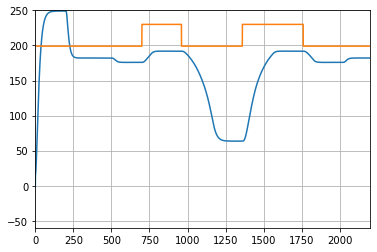

In [9]:
# Cette partie du code est dédiée à un exemple de simulation avec l'usine, où nous définissons comme action un échelon de 250 
# à partir de 200 secondes.

T_SENSOR = []
FAV_POS = []
time_v = []

# Initialisation des listas pour sauvegarder les résultats de validation

T_SENSOR.append(0)
FAV_POS.append(0)
time_v.append(0)

# Initialisation du cas test

step_size = 10**(-2)
CaseTest = C_T01(step_size)

# Initialisation de la plante

env = PlantEnv(CaseTest,2.0,step_size)
done = False

state = env.reset()
print(state)

# Simulation (Attention, la simulation retourne done=True lorsqu'elle était fini)

while done==False:
    action = 0.0 if env.time < 200 else 250
    
    TBAS_SENSOR, reward, done, _ = env.step(action)
    
    T_SENSOR.append(TBAS_SENSOR)
    time_v.append(env.time)
    
    print(reward)
Temp_tgt = CaseTest.getT_tgt_C()
    
plt.plot(time_v,T_SENSOR)    
plt.plot(time_v,Temp_tgt[0:(len(time_v))])
plt.axis([0,time_v[len(time_v)-1],-60,250])
plt.grid()